# Unsupervised Learning Trading Strategy

1. Download S&P500 stock prices data
2. Calculate different features and indicators on each stock
3. Aggregate on monthly level and filter top 150 most liquid stocks
4. Calculate number of technical indicators, feature for each stock 
5. Download Fama-French Factors and Calculate Rolling Factor Betas
6. For each month, fit a K-Means Clusterings Algorithm to group similiar asssets based on their features
7. For each month, select assets based on the cluster and form a porfolio based on Efficient Frontier max sharpe ratio optimization
8. Visualize Portfolio returns and Compare to S&P500 returns

## Install Packages Needs:
- pandas, numpy, matplotlib, statsmodels, pandas_datareader, datatime, yfinance, sklearn, PyPorfolioOpt

In [245]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install statsmodels
!pip install pandas_datareader
!pip install datetime
!pip install yfinance
!pip install scikit-learn
!pip install PyPortfolioOpt

  Using cached pyportfolioopt-1.5.2-py3-none-any.whl (61 kB)
  Using cached cvxpy-1.3.4.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     -------------------------------------- 293.1/293.1 kB 6.0 MB/s eta 0:00:00
     ---------------------------------------- 71.7/71.7 kB 4.1 MB/s eta 0:00:00
  Using cached scs-3.2.6.tar.gz (1.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): star

  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [30 lines of output]
  + meson setup C:\Users\nguye\AppData\Local\Temp\pip-install-ku2r1rlr\scs_5e5c5a47c34a4a9ca910054f083ac5ef C:\Users\nguye\AppData\Local\Temp\pip-install-ku2r1rlr\scs_5e5c5a47c34a4a9ca910054f083ac5ef\.mesonpy-zmcjrxkw -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\nguye\AppData\Local\Temp\pip-install-ku2r1rlr\scs_5e5c5a47c34a4a9ca910054f083ac5ef\.mesonpy-zmcjrxkw\meson-python-native-file.ini
  The Meson build system
  Version: 1.5.1
  Source dir: C:\Users\nguye\AppData\Local\Temp\pip-install-ku2r1rlr\scs_5e5c5a47c34a4a9ca910054f083ac5ef
  Build dir: C:\Users\nguye\AppData\Local\Temp\pip-install-ku2r1rlr\scs_5e5c5a47c34a4a9ca910054f083ac5ef\.mesonpy-zmcjrxkw
  Build type: native build
  Project name: scs
  Project version: undefined
  C compiler for the host machine: gcc (gcc 6.3.0 "gcc (MinGW.org GCC-6.3.0-1) 6.

In [246]:
!pip install pandas_ta

## 1. Download S&P500 stock prices data

In [247]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [272]:
#read the S&P500 from Wikipedia
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

#Clean the Symbol bolumn: replace '.' with '-'
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')

# Extract a Symbol list
symbols_list = sp500['Symbol'].unique().tolist()
symbols_list

#define end_date and start_date(8years from end_date)
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date)- pd.DateOffset(365*8)

# #Download the stock prices based on the end_date, start_date, sp500
df = yf.download(tickers = symbols_list,
                 start = start_date,
                 end = end_date).stack()


[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['GEV', 'SOLV', 'SW', 'VLTO']: YFChartError("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")


In [273]:
# Dataframe cleaning

# Add column names for date and tickers
df.index.names = ['date', 'tickers']

#conver column names to lower case
df.columns = df.columns.str.lower()


In [274]:
df

Price                adj close       close        high         low  \
date       tickers                                                   
2015-09-29 A         31.425234   33.740002   34.060001   33.240002   
           AAL       37.361618   39.180000   39.770000   38.790001   
           AAPL      24.651133   27.264999   28.377501   26.965000   
           ABBV      36.004158   52.790001   54.189999   51.880001   
           ABT       33.302025   39.500000   40.150002   39.029999   
...                        ...         ...         ...         ...   
2023-09-26 XYL       88.736298   89.519997   90.849998   89.500000   
           YUM      122.211014  124.010002  124.739998  123.449997   
           ZBH      111.534821  112.459999  117.110001  112.419998   
           ZBRA     223.960007  223.960007  226.649994  222.580002   
           ZTS      175.131134  176.869995  178.449997  176.270004   

Price                     open       volume  
date       tickers                           
2015-09-29 A         33.360001    2252400.0  
           AAL       39.049999    7478800.0  
           AAPL      28.207500  293461600.0  
           ABBV      53.099998   12842800.0  
           ABT       39.259998   12287500.0  
...                        ...          ...  
2023-09-26 XYL       90.379997    1322400.0  
           YUM      124.239998    1500600.0  
           ZBH      116.769997    3610500.0  
           ZBRA     225.970001     355400.0  
           ZTS      176.580002    1463200.0  

[985955 rows x 6 columns]

## 2. Calculate different features and indicators on each stock:
   - Garman-Klass Volatility
   - RSI
   - Bolinger Bands
   - ATR
   - MACD
   - Dollar Volumn

Garman Klass is a volatility estimator that incorporates open, low, high, and close prices of a security.

Garman-Klass volitatlity = (ln(High) - ln(Low))^2/2 - (2ln(2)-1)(ln(AdjClose)-ln(Open))^2

In [275]:
#Calculate  Garman-Klass Volatility
df['garman_klass_vol'] = (
    (np.log(df['high']) - np.log(df['low']))**2 / 2 
    - (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open']))**2)
)

# Calculate RSI
df['rsi'] = df.groupby(level = 1)['adj close'].transform(lambda x: pandas_ta.rsi(close = x, length = 20))

# Calculate Bolinger Bands
df['bb_low'] = df.groupby(level = 1)['adj close'].transform(lambda x : pandas_ta.bbands(close = np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level = 1)['adj close'].transform(lambda x : pandas_ta.bbands(close = np.log1p(x), length=20).iloc[:,1])
df['bb_high'] = df.groupby(level = 1)['adj close'].transform(lambda x : pandas_ta.bbands(close = np.log1p(x), length=20).iloc[:,2])

#Calculate ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high = stock_data['high'],
                        low = stock_data['low'],
                        close = stock_data['close'],
                        length = 14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level = 1, group_keys = False).apply(compute_atr)

#Calcule MACD
def compute_macd(close):
    macd = pandas_ta.macd(close = close, length = 20).iloc[:,0]
    #return the normalize value of macd for clustering 
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level = 1, group_keys = False)['adj close'].apply(compute_macd)

#Calculate dolar volumn
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price                adj close       close        high         low  \
date       tickers                                                   
2015-09-29 A         31.425234   33.740002   34.060001   33.240002   
           AAL       37.361618   39.180000   39.770000   38.790001   
           AAPL      24.651133   27.264999   28.377501   26.965000   
           ABBV      36.004158   52.790001   54.189999   51.880001   
           ABT       33.302025   39.500000   40.150002   39.029999   
...                        ...         ...         ...         ...   
2023-09-26 XYL       88.736298   89.519997   90.849998   89.500000   
           YUM      122.211014  124.010002  124.739998  123.449997   
           ZBH      111.534821  112.459999  117.110001  112.419998   
           ZBRA     223.960007  223.960007  226.649994  222.580002   
           ZTS      175.131134  176.869995  178.449997  176.270004   

Price                     open       volume  garman_klass_vol        rsi  \
date       tickers                                                         
2015-09-29 A         33.360001    2252400.0         -0.001082        NaN   
           AAL       39.049999    7478800.0         -0.000443        NaN   
           AAPL      28.207500  293461600.0         -0.005712        NaN   
           ABBV      53.099998   12842800.0         -0.057368        NaN   
           ABT       39.259998   12287500.0         -0.010064        NaN   
...                        ...          ...               ...        ...   
2023-09-26 XYL       90.379997    1322400.0         -0.000018  26.146739   
           YUM      124.239998    1500600.0         -0.000051  36.057161   
           ZBH      116.769997    3610500.0          0.000022  31.893226   
           ZBRA     225.970001     355400.0          0.000133  29.494977   
           ZTS      176.580002    1463200.0          0.000049  42.623465   

Price                 bb_low    bb_mid   bb_high       atr      macd  \
date       tickers                                                     
2015-09-29 A             NaN       NaN       NaN       NaN       NaN   
           AAL           NaN       NaN       NaN       NaN       NaN   
           AAPL          NaN       NaN       NaN       NaN       NaN   
           ABBV          NaN       NaN       NaN       NaN       NaN   
           ABT           NaN       NaN       NaN       NaN       NaN   
...                      ...       ...       ...       ...       ...   
2023-09-26 XYL      4.485761  4.567684  4.649607  0.033800 -2.159189   
           YUM      4.811707  4.841672  4.871637  0.142547 -1.363695   
           ZBH      4.745884  4.785551  4.825217 -0.381708 -0.881067   
           ZBRA     5.400991  5.539167  5.677342 -0.057389 -1.600791   
           ZTS      5.153746  5.212559  5.271371  0.651515 -1.188278   

Price               dollar_volume  
date       tickers                 
2015-09-29 A            70.782197  
           AAL         279.420069  
           AAPL       7234.160810  
           ABBV        462.394201  
           ABT         409.198630  
...                           ...  
2023-09-26 XYL         117.344880  
           YUM         183.389847  
           ZBH         402.696470  
           ZBRA         79.595386  
           ZTS         256.251875  

[985955 rows x 14 columns]

<AxesSubplot:xlabel='date'>

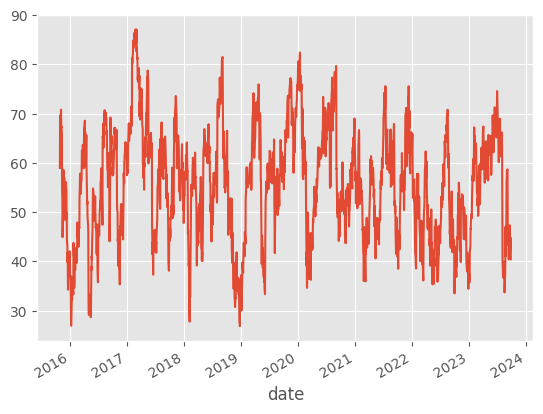

In [276]:
#plot AAPl rsi
df.xs('AAPL', level=1)['rsi'].plot()

## 3.Aggregate on monthly level and filter top 150 most liquid stocks
- To reduce training time and experiment with features and strategies, we convert the business daily data to month-end frequency

In [286]:
#Create a list columns of the aggregate columns to perform the same opertion on these columns 
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open','high','low','close']]

# Unstack ticker level, calculate the monthly mean
data = pd.concat([df.unstack('tickers')['dollar_volume'].resample('M').mean().stack('tickers').to_frame('dollar_volume'),
            df.unstack()[last_cols].resample('M').last().stack('tickers')],
            axis = 1)

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       tickers                                                            
2015-09-30 A            76.090162   31.974752       NaN       NaN       NaN   
           AAL         432.669050   37.027878       NaN       NaN       NaN   
           AAPL       6931.612631   24.931417       NaN       NaN       NaN   
           ABBV        451.912412   37.109043       NaN       NaN       NaN   
           ABT         386.865566   33.909054       NaN       NaN       NaN   
...                           ...         ...       ...       ...       ...   
2023-09-30 XYL         174.136225   88.736298  0.033800  4.649607  4.485761   
           YUM         175.065307  122.211014  0.142547  4.871637  4.811707   
           ZBH         191.405611  111.534821 -0.381708  4.825217  4.745884   
           ZBRA        105.780863  223.960007 -0.057389  5.677342  5.400991   
           ZTS         286.837281  175.131134  0.651515  5.271371  5.153746   

                      bb_mid  garman_klass_vol      macd        rsi  
date       tickers                                                   
2015-09-30 A             NaN         -0.001322       NaN        NaN  
           AAL           NaN          0.000050       NaN        NaN  
           AAPL          NaN         -0.003507       NaN        NaN  
           ABBV          NaN         -0.051684       NaN        NaN  
           ABT           NaN         -0.009795       NaN        NaN  
...                      ...               ...       ...        ...  
2023-09-30 XYL      4.567684         -0.000018 -2.159189  26.146739  
           YUM      4.841672         -0.000051 -1.363695  36.057161  
           ZBH      4.785551          0.000022 -0.881067  31.893226  
           ZBRA     5.539167          0.000133 -1.600791  29.494977  
           ZTS      5.212559          0.000049 -1.188278  42.623465  

[47531 rows x 9 columns]

- Calculate 5 - year rolling average of dollar volume for each stocks before filtering

In [287]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('tickers').rolling(5*12, min_periods =12).mean().stack())

#Order the dollar_volumn by ascending
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending = False))

#Select the top 150
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       tickers                                                       
2016-08-31 AAL       34.989559 -0.182377  3.624501  3.511263  3.567882   
           AAPL      24.494833 -1.117074  3.275645  3.235305  3.255475   
           ABBV      45.408333 -1.370909  3.899057  3.835019  3.867038   
           ABT       36.298466 -1.036629  3.710207  3.624830  3.667518   
           ACN      100.967079 -1.077084  4.631977  4.598804  4.615390   
...                        ...       ...       ...       ...       ...   
2023-09-30 VRTX     351.690002  0.029799  5.879295  5.838959  5.859127   
           VZ        30.755373 -1.078816  3.516245  3.451862  3.484054   
           WFC       39.781086 -0.558742  3.777782  3.697055  3.737418   
           WMT       53.597538 -0.196381  4.019915  3.984976  4.002446   
           XOM      113.372101  0.601335  4.767283  4.687091  4.727187   

                    garman_klass_vol      macd        rsi  
date       tickers                                         
2016-08-31 AAL             -0.000479  0.886262  56.204579  
           AAPL            -0.002162 -0.137743  55.385063  
           ABBV            -0.046259 -0.285620  44.920439  
           ABT             -0.010390 -0.295060  41.307296  
           ACN             -0.006450 -0.143837  52.918823  
...                              ...       ...        ...  
2023-09-30 VRTX             0.000037  0.027907  52.406728  
           VZ              -0.001680 -0.350386  42.222484  
           WFC             -0.000110 -0.282326  40.920278  
           WMT             -0.000041  0.399458  54.722532  
           XOM             -0.000065  1.400623  59.440187  

[12814 rows x 8 columns]

## 4. Calculate number of technical indicators, feature for each stock 

- To capture time series dynamics that reflect the retuns over various monthly
  E.g.: the momentum patterns, we compute histtorical returns using method .pct_change(lag), that is, the returns over various monthly period as indentified by lags

In [288]:
def calculate_returns(df):
    #Define threshold cutoff of that percentage: 90%
    outlier_cutoff = 0.005
    
    #number of months 
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                       upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df

data = data.groupby(level = 1, group_keys = False).apply(calculate_returns).dropna()
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       tickers                                                       
2017-08-31 AAL       43.511288  0.159033  3.936447  3.741600  3.839023   
           AAPL      38.529812 -0.931918  3.678805  3.622255  3.650530   
           ABBV      55.412022 -1.376602  4.022875  3.944742  3.983809   
           ABT       45.090450 -1.157827  3.825750  3.773206  3.799478   
           ACN      117.201630 -1.132070  4.773213  4.746614  4.759914   
...                        ...       ...       ...       ...       ...   
2023-09-30 VRTX     351.690002  0.029799  5.879295  5.838959  5.859127   
           VZ        30.755373 -1.078816  3.516245  3.451862  3.484054   
           WFC       39.781086 -0.558742  3.777782  3.697055  3.737418   
           WMT       53.597538 -0.196381  4.019915  3.984976  4.002446   
           XOM      113.372101  0.601335  4.767283  4.687091  4.727187   

                    garman_klass_vol      macd        rsi  return_1m  \
date       tickers                                                     
2017-08-31 AAL             -0.000146 -1.736995  37.643881  -0.111206   
           AAPL            -0.001368  0.056940  65.282883   0.106999   
           ABBV            -0.032460  0.104924  68.425745   0.077099   
           ABT             -0.004445  0.071077  62.800400   0.035787   
           ACN             -0.004114 -0.079960  59.510459   0.015060   
...                              ...       ...        ...        ...   
2023-09-30 VRTX             0.000037  0.027907  52.406728   0.009617   
           VZ              -0.001680 -0.350386  42.222484  -0.056890   
           WFC             -0.000110 -0.282326  40.920278  -0.015500   
           WMT             -0.000041  0.399458  54.722532  -0.000676   
           XOM             -0.000065  1.400623  59.440187   0.046947   

                    return_2m  return_3m  return_6m  return_9m  return_12m  
date       tickers                                                          
2017-08-31 AAL      -0.056118  -0.025279  -0.005218  -0.003427    0.018330  
           AAPL      0.069206   0.025287   0.031829   0.046264    0.038469  
           ABBV      0.023627   0.047937   0.036617   0.027342    0.016730  
           ABT       0.026514   0.039058   0.022555   0.034961    0.018239  
           ACN       0.028224   0.016569   0.012675   0.011280    0.012503  
...                       ...        ...        ...        ...         ...  
2023-09-30 VRTX     -0.000923  -0.000208   0.018495   0.022140    0.016337  
           VZ       -0.016122  -0.033458  -0.021495  -0.014100   -0.006158  
           WFC      -0.057917  -0.013554   0.016712   0.000702    0.003255  
           WMT       0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM       0.046139   0.030496   0.012838   0.008747    0.027037  

[10634 rows x 14 columns]

## 5.Download Fama-French Factors and Calculate Rolling Factor Betas
- Fama-French data: to estimate the exposure of assets to common risks fators using linear regression
- 5 common Fama-French data: size, value, operating profitability, and investment have been shown empirically returns are common use to access risk/returns profile of portfolios. Hence, it is natural to include past factor exposures models
- We can access the historical factor return using pandas-datareader and estimate the historical exposure using RollingOLS

In [289]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       tickers                                                   
2017-08-31 AAL      0.0016 -0.0182 -0.0209  0.0014 -0.0238  -0.111206
           AAPL     0.0016 -0.0182 -0.0209  0.0014 -0.0238   0.106999
           ABBV     0.0016 -0.0182 -0.0209  0.0014 -0.0238   0.077099
           ABT      0.0016 -0.0182 -0.0209  0.0014 -0.0238   0.035787
           ACN      0.0016 -0.0182 -0.0209  0.0014 -0.0238   0.015060
...                    ...     ...     ...     ...     ...        ...
2023-09-30 VRTX    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ      -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000676
           XOM     -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10634 rows x 6 columns]

In [290]:
#Check MSFT
factor_data.xs('MSFT', level = 1).head()

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date                                                         
2017-08-31  0.0016 -0.0182 -0.0209  0.0014 -0.0238   0.033953
2017-09-30  0.0251  0.0478  0.0314 -0.0147  0.0169  -0.003745
2017-10-31  0.0225 -0.0194  0.0020  0.0093 -0.0325   0.116660
2017-11-30  0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.016984
2017-12-31  0.0106 -0.0107  0.0006  0.0074  0.0169   0.016277

- Filter the stocks have less than 10 month of data

In [292]:
observations = factor_data.groupby(level=1).size() 

valid_stocks = observations[observations >=10]

factor_data =factor_data[factor_data.index.get_level_values('tickers').isin(valid_stocks.index)]

In [293]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       tickers                                                   
2017-08-31 AAL      0.0016 -0.0182 -0.0209  0.0014 -0.0238  -0.111206
           AAPL     0.0016 -0.0182 -0.0209  0.0014 -0.0238   0.106999
           ABBV     0.0016 -0.0182 -0.0209  0.0014 -0.0238   0.077099
           ABT      0.0016 -0.0182 -0.0209  0.0014 -0.0238   0.035787
           ACN      0.0016 -0.0182 -0.0209  0.0014 -0.0238   0.015060
...                    ...     ...     ...     ...     ...        ...
2023-09-30 VRTX    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ      -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000676
           XOM     -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10619 rows x 6 columns]

- Calculate Rolling Factor Betas

In [294]:
betas = (factor_data.groupby(level=1,group_keys = False)
             .apply(lambda x : RollingOLS(endog=x['return_1m'],
                                         exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                         window = min(24, x.shape[0]),
                                         min_nobs = len(x.columns)+1)
            .fit(params_only = True)
            .params
            .drop('const', axis = 1)
))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       tickers                                                  
2017-08-31 AAL           NaN       NaN       NaN       NaN       NaN
           AAPL          NaN       NaN       NaN       NaN       NaN
           ABBV          NaN       NaN       NaN       NaN       NaN
           ABT           NaN       NaN       NaN       NaN       NaN
           ACN           NaN       NaN       NaN       NaN       NaN
...                      ...       ...       ...       ...       ...
2023-09-30 VRTX     0.459811 -0.435975 -0.321264 -0.063427  0.815883
           VZ       0.332705 -0.165968  0.265662  0.311128  0.108810
           WFC      1.120622  0.297484  2.062607 -0.441340 -1.519517
           WMT      0.700776 -0.313576 -0.413665 -0.141575  0.508827
           XOM      0.982764 -1.094982  1.756380 -0.640264 -0.369404

[10619 rows x 5 columns]

- Create Feature

In [295]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']

# #Shift betas 1 month forward 
data = (data.join(betas.groupby('tickers').shift()))

data.loc[:,factors] = data.groupby('tickers', group_keys = False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10362 entries, (Timestamp('2017-08-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10362 non-null  float64
 1   bb_high           10362 non-null  float64
 2   bb_low            10362 non-null  float64
 3   bb_mid            10362 non-null  float64
 4   garman_klass_vol  10362 non-null  float64
 5   macd              10362 non-null  float64
 6   rsi               10362 non-null  float64
 7   return_1m         10362 non-null  float64
 8   return_2m         10362 non-null  float64
 9   return_3m         10362 non-null  float64
 10  return_6m         10362 non-null  float64
 11  return_9m         10362 non-null  float64
 12  return_12m        10362 non-null  float64
 13  Mkt-RF            10362 non-null  float64
 14  SMB               10362 non-null  float64
 15  HML        

## Decide which ML model to perform K-Means Clustering
## For each month, fit a K-Means Clusterings Algorithm to group similiar asssets based on their features

### K-Means Clustering
- Number of clusters: k = 4
- Initialization: K-Means++ initialization
-  Pre-defined our centroids for each cluster

### Random initialization 

In [296]:
#Import the important library
from sklearn.cluster import KMeans

#create a function to assign the cluster to the data
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                          random_state=0,
                          init='random').fit(df).labels_
    return df

#Assign the cluster to the data
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)



- Visualize data using scatter plot

In [323]:
def plot_clusters(data):
    #Extract the data to cluster group
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    #Plot using base on cluster
    plt.scatter(cluster_0.iloc[:,0], cluster_0.iloc[:,6], color = 'red', label='cluster 0', alpha = 0.5)
    plt.scatter(cluster_1.iloc[:,0], cluster_1.iloc[:,6], color = 'blue', label='cluster 1', alpha = 0.5)
    plt.scatter(cluster_2.iloc[:,0], cluster_2.iloc[:,6], color = 'green', label='cluster 2', alpha = 0.5)
    plt.scatter(cluster_3.iloc[:,0], cluster_3.iloc[:,6], color = 'yellow', label='cluster 3', alpha = 0.5)

    plt.legend()
    plt.show()
    return

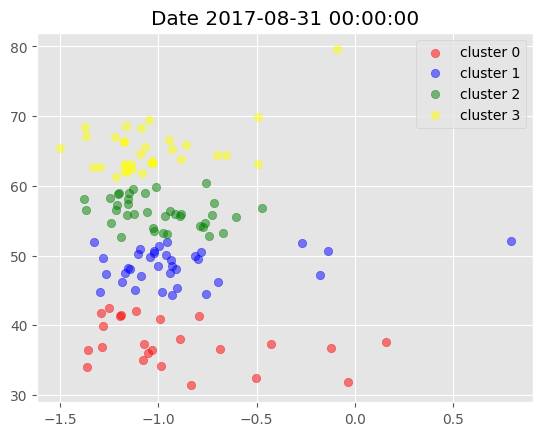

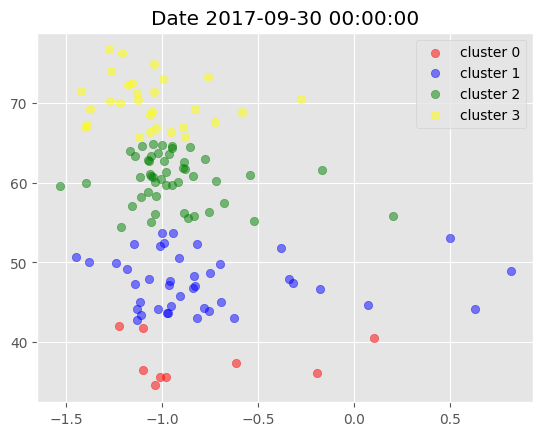

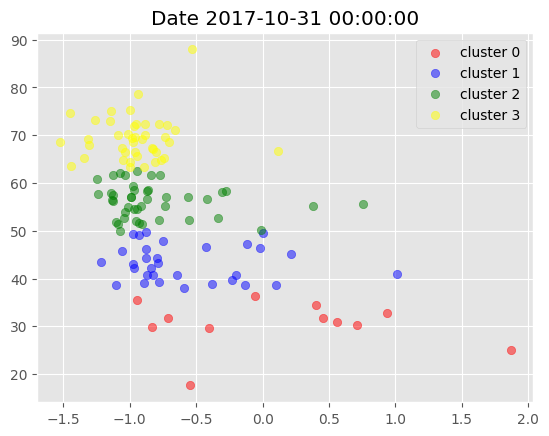

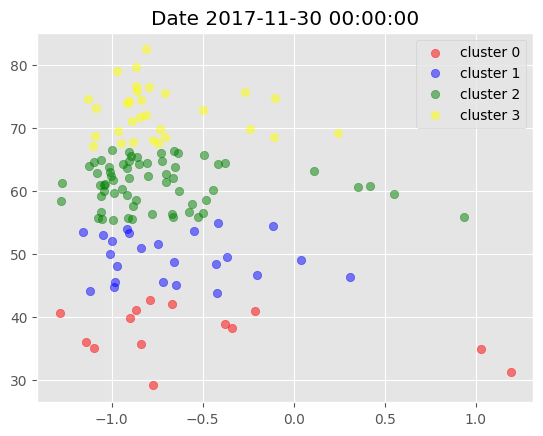

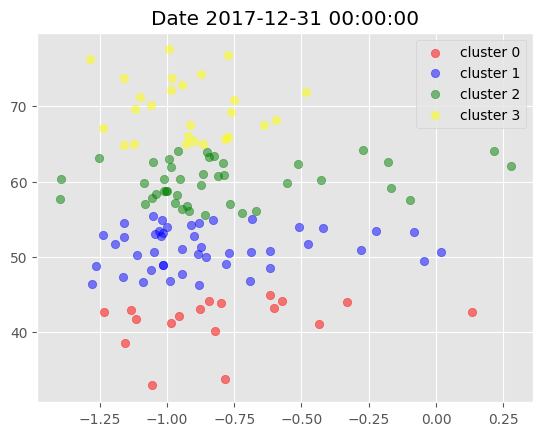

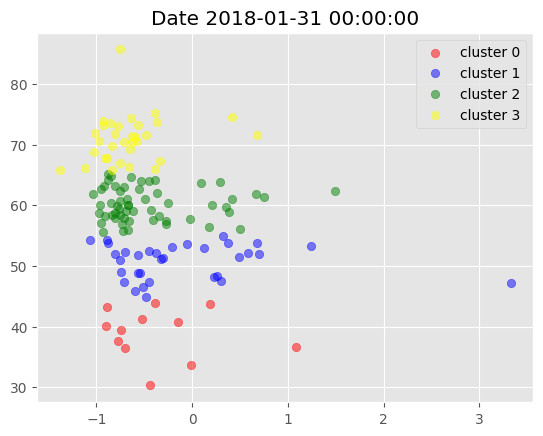

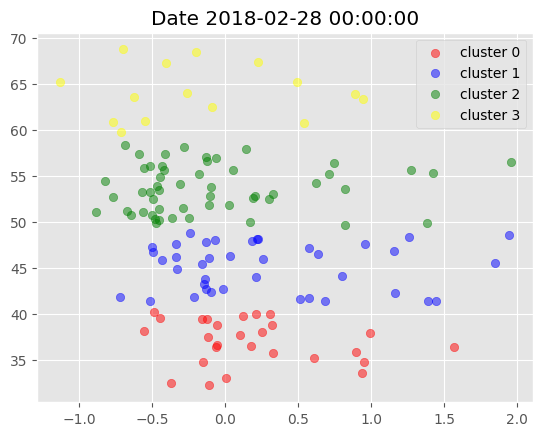

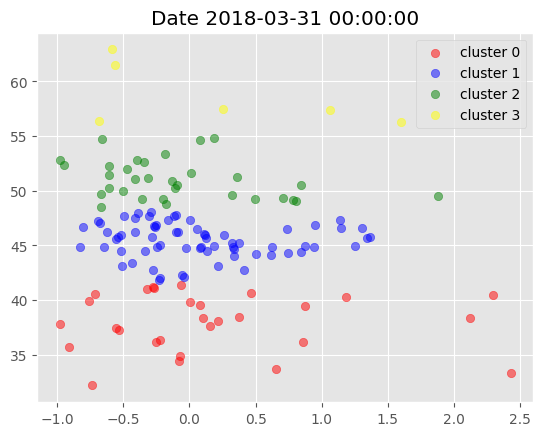

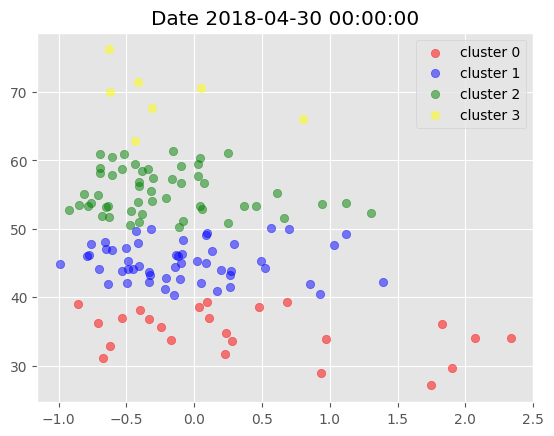

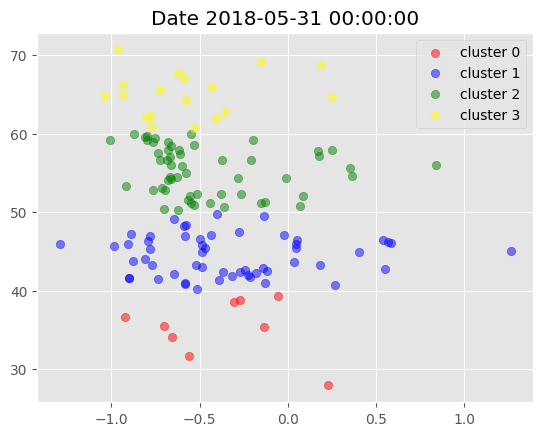

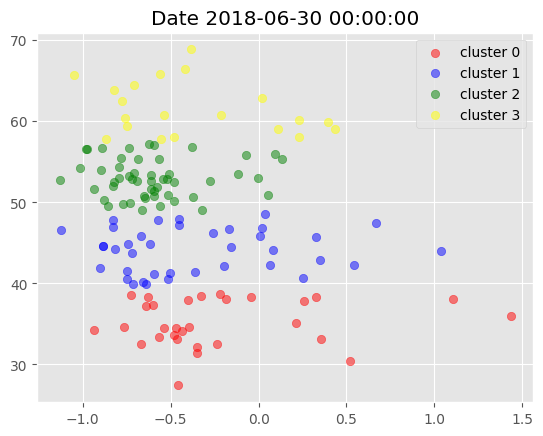

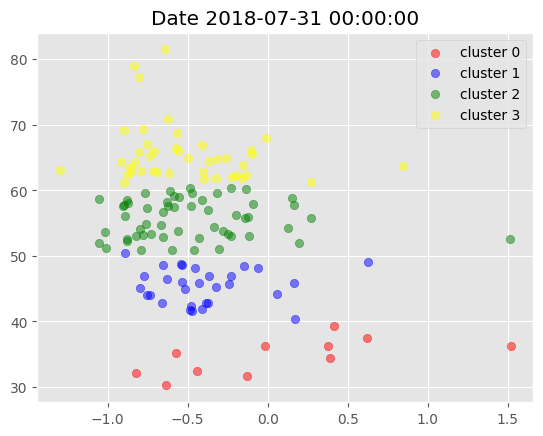

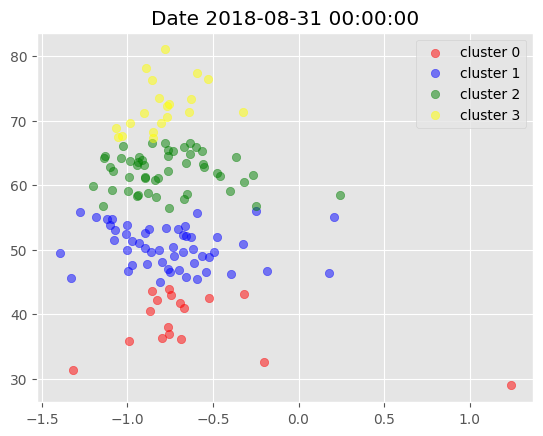

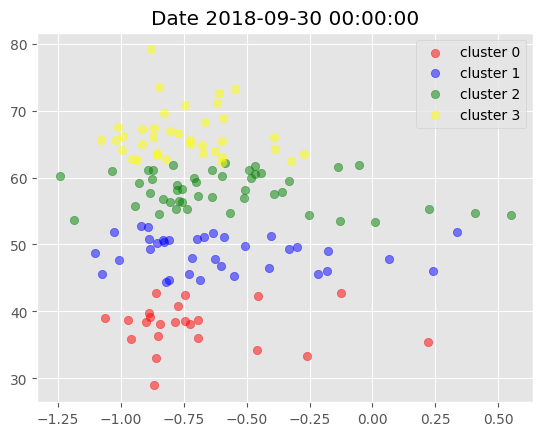

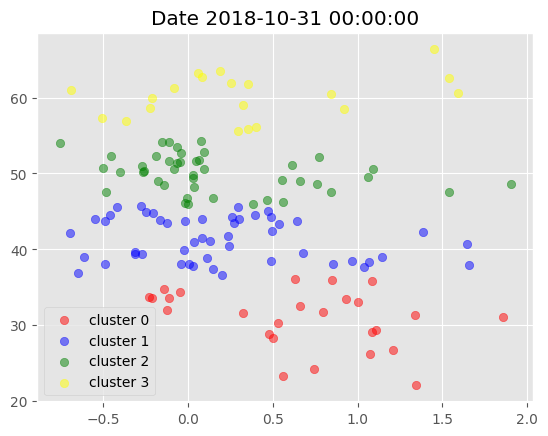

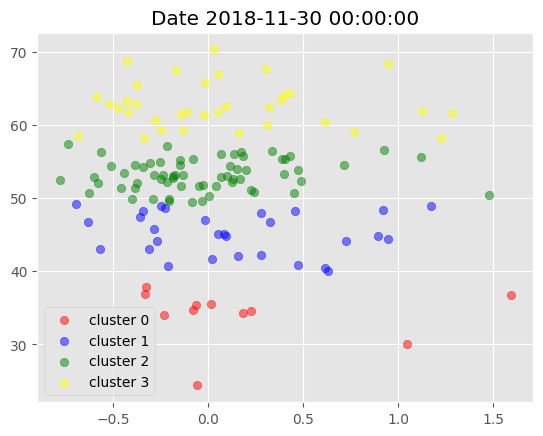

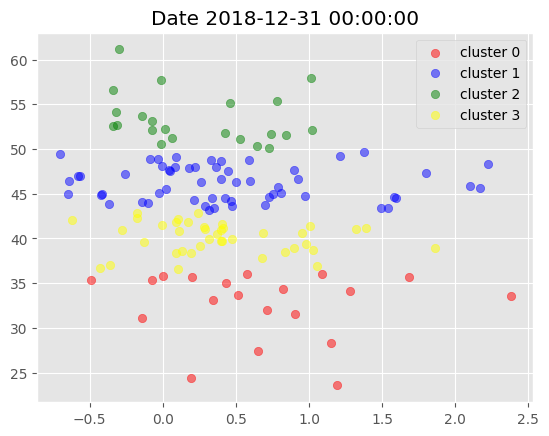

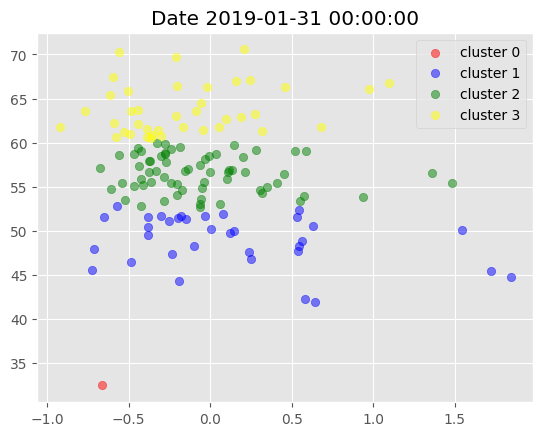

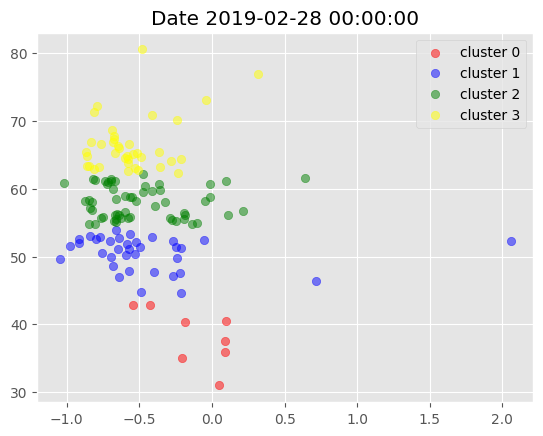

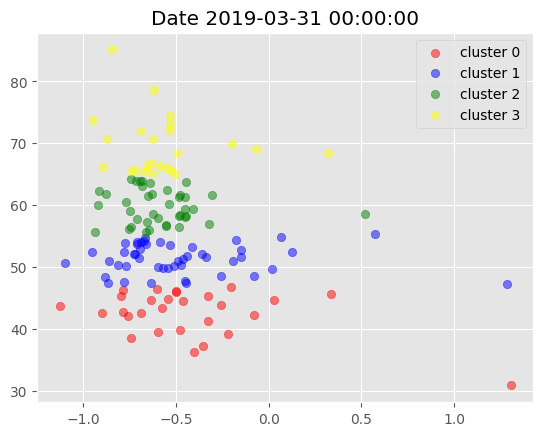

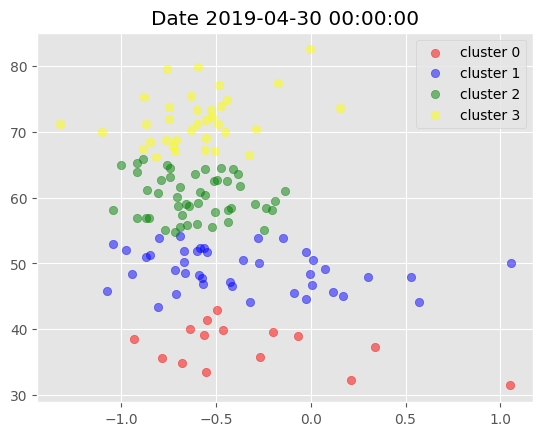

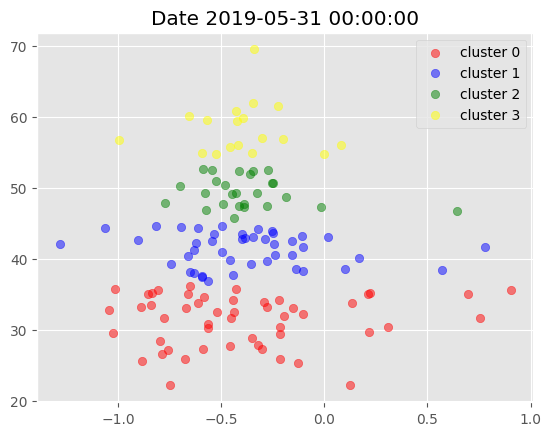

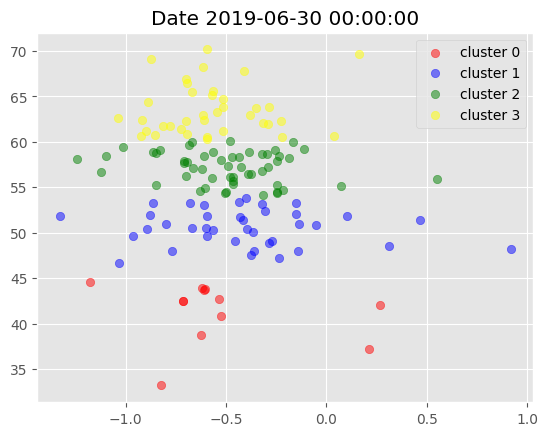

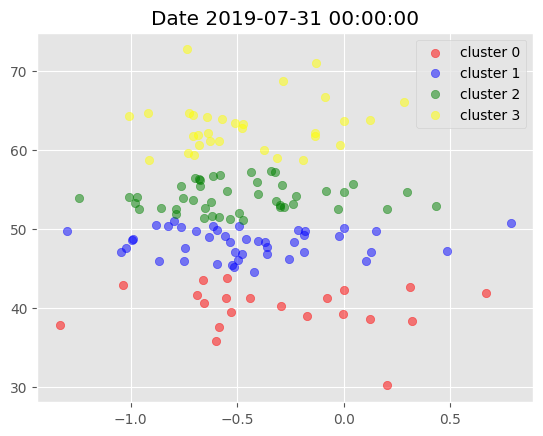

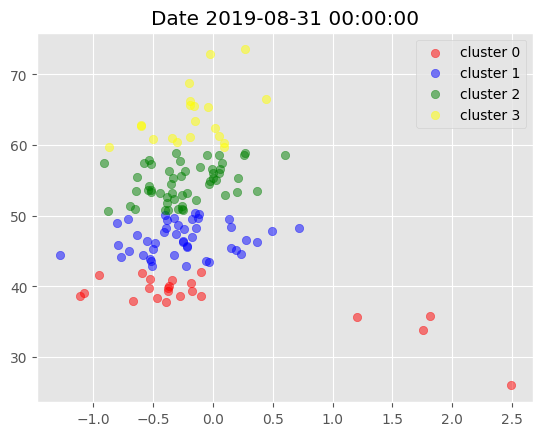

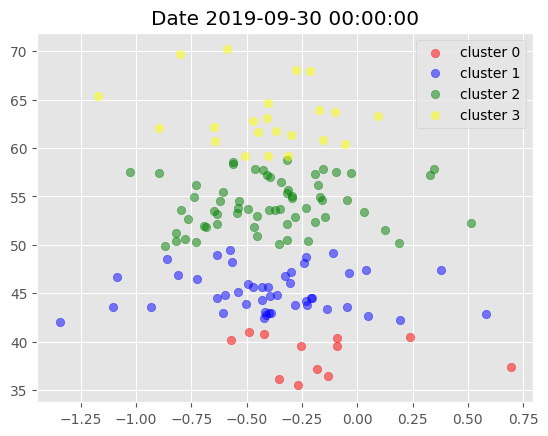

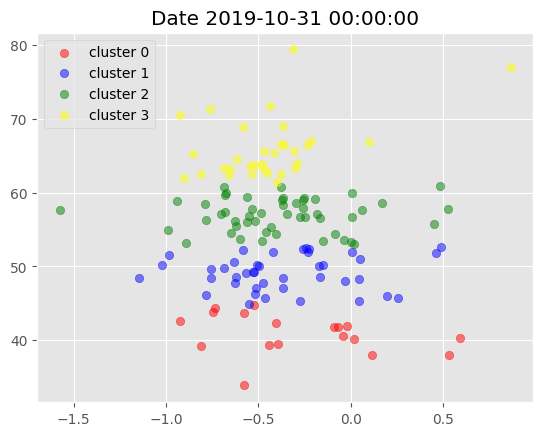

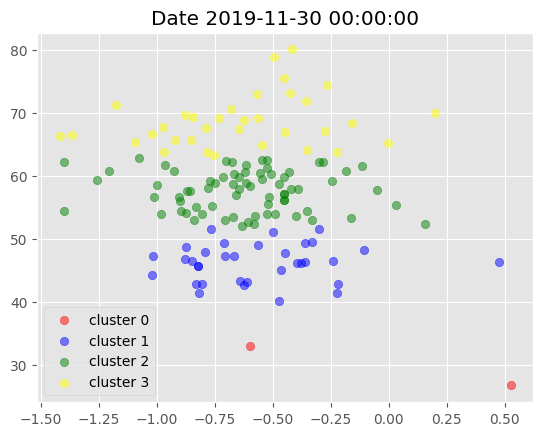

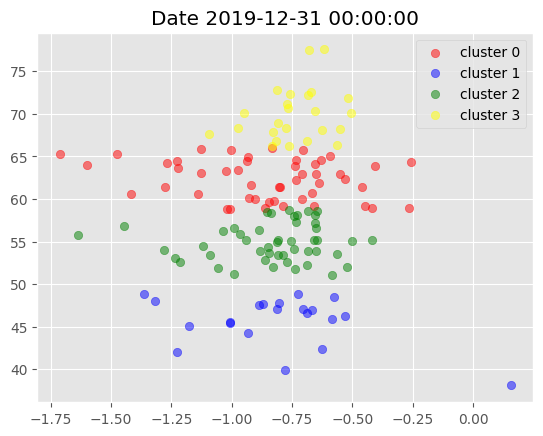

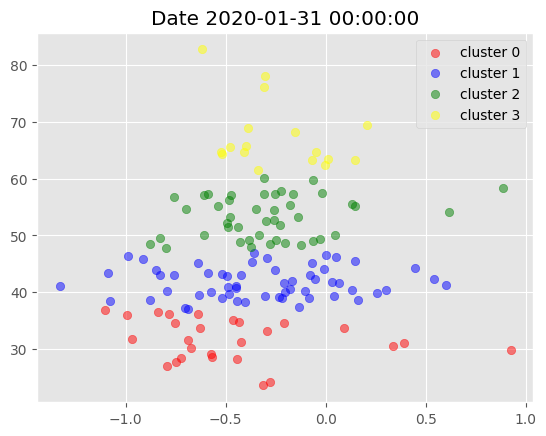

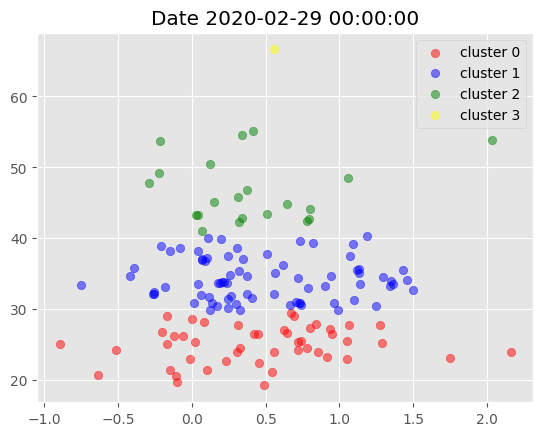

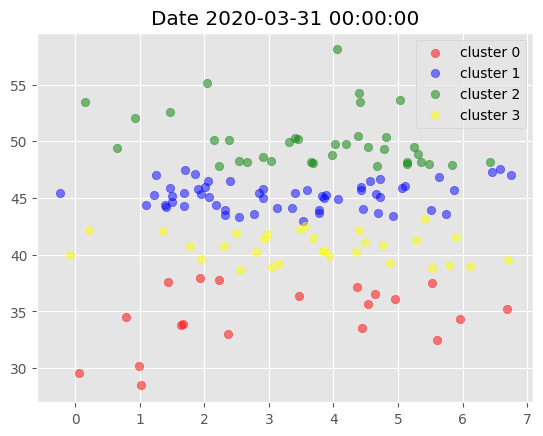

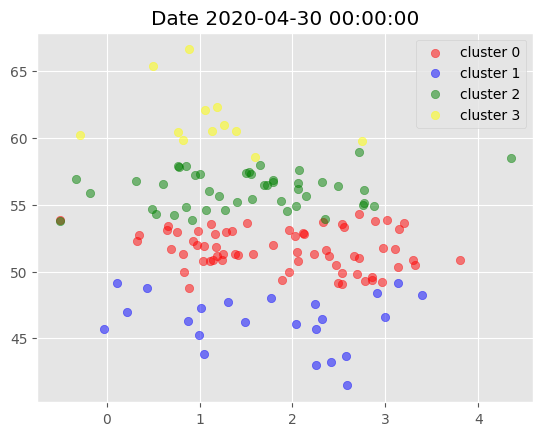

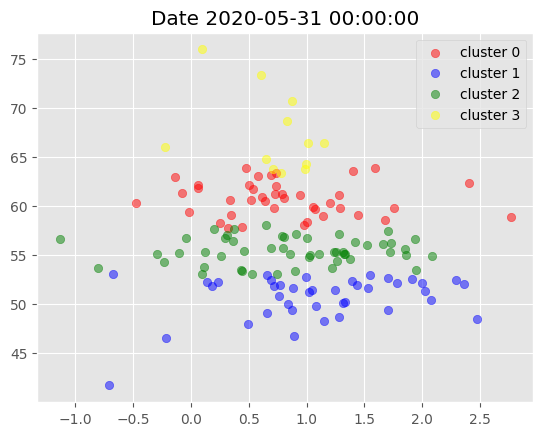

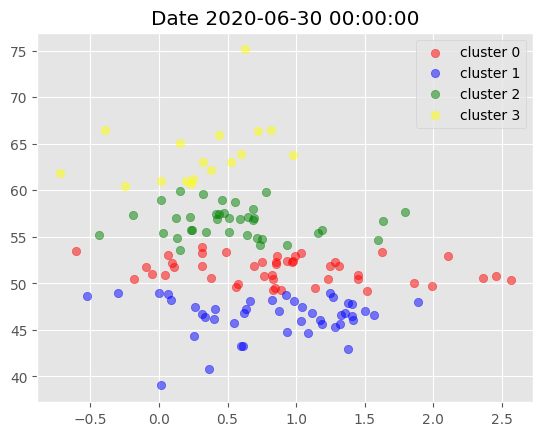

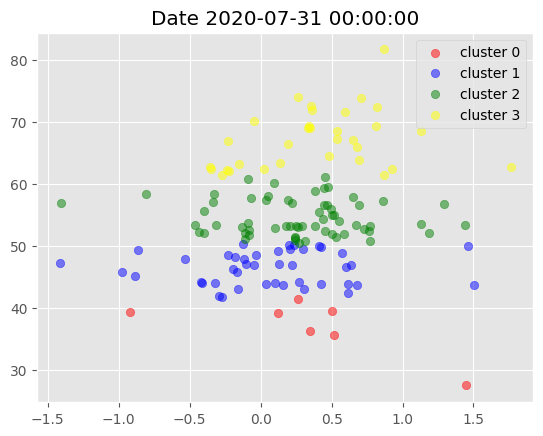

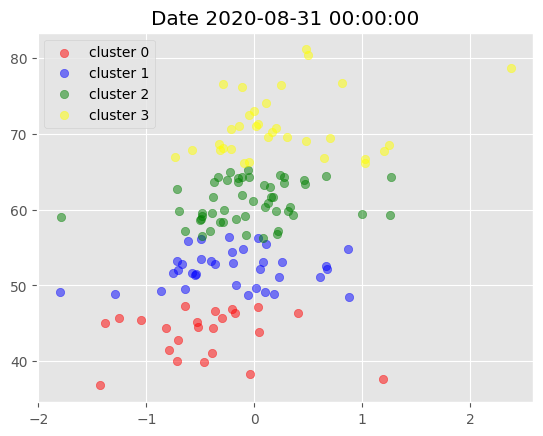

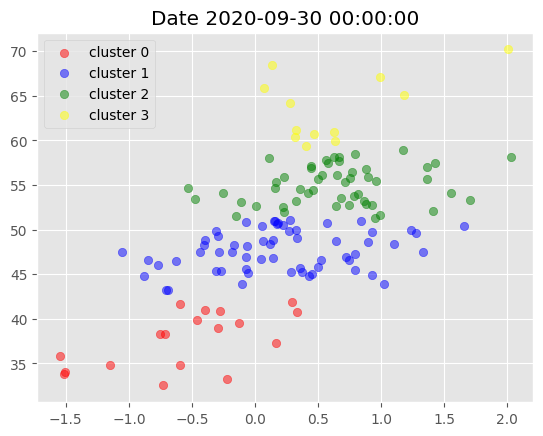

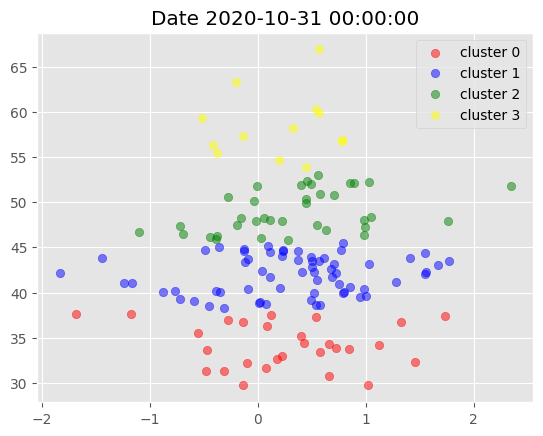

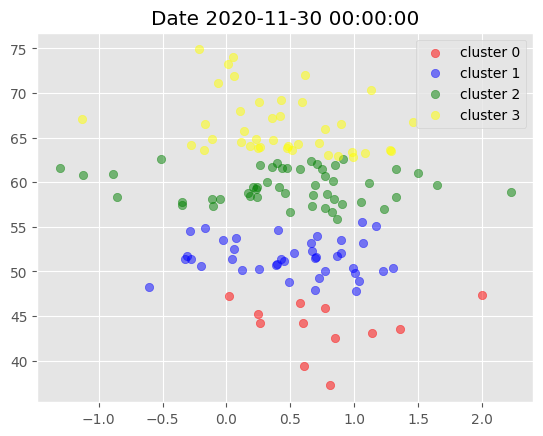

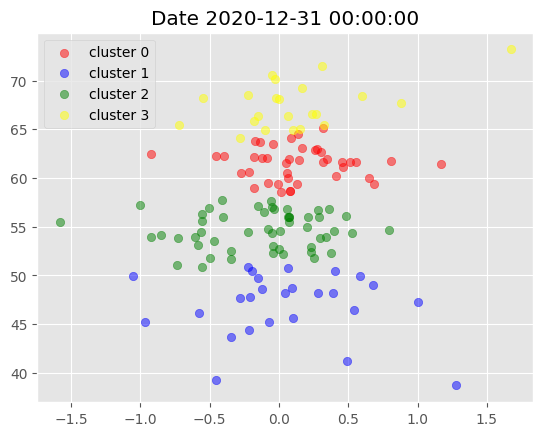

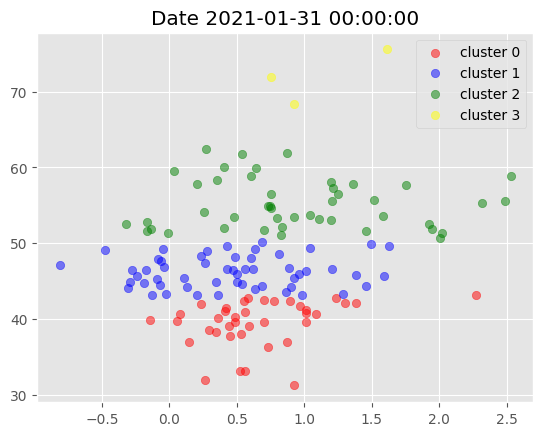

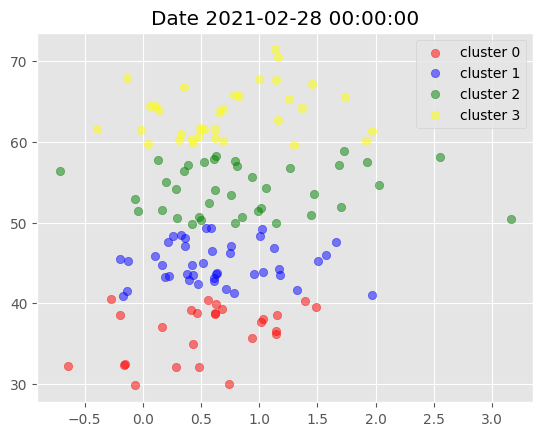

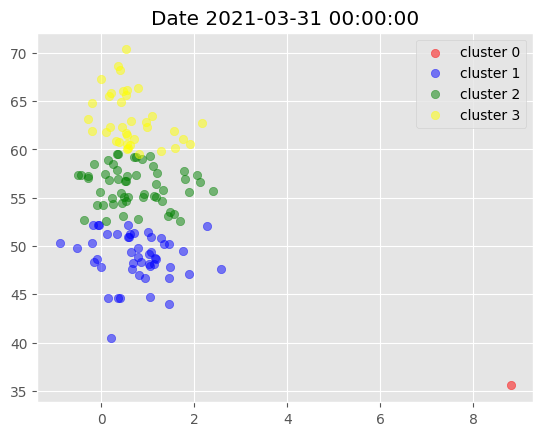

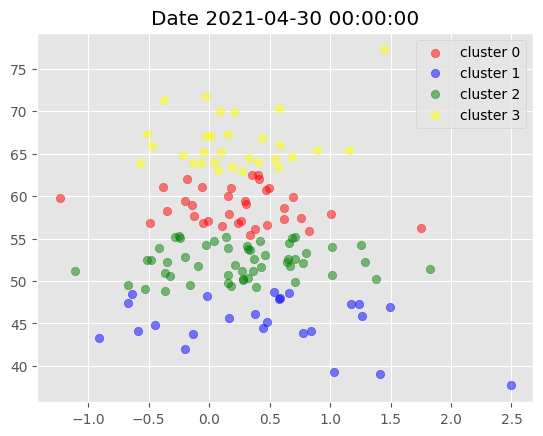

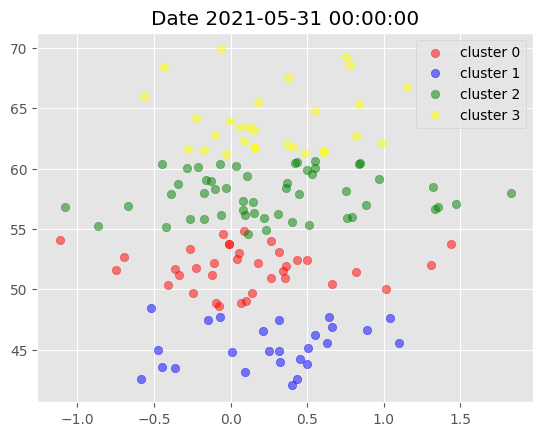

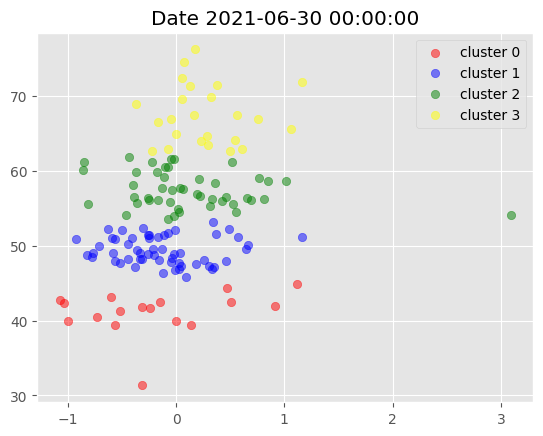

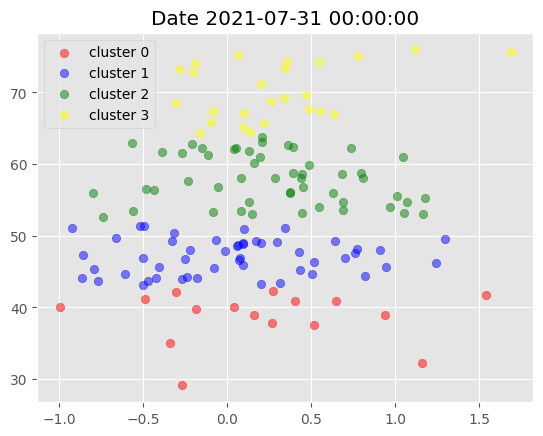

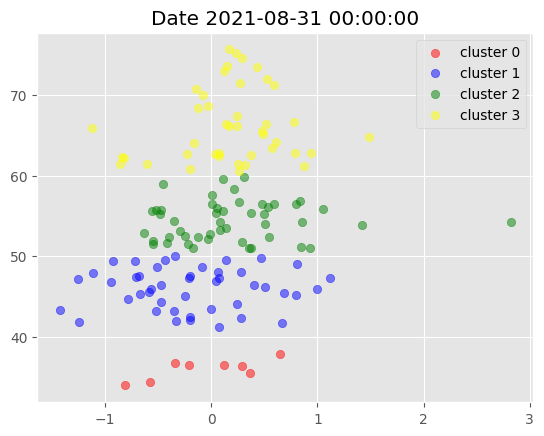

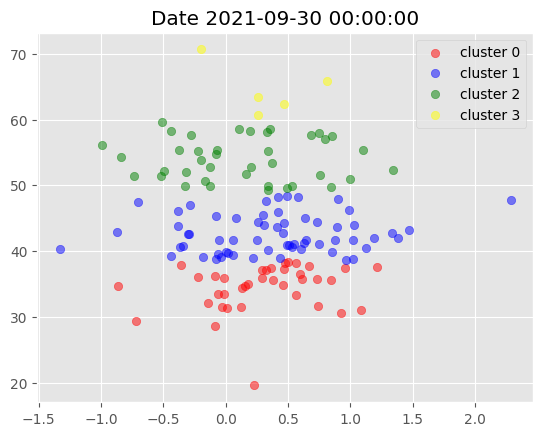

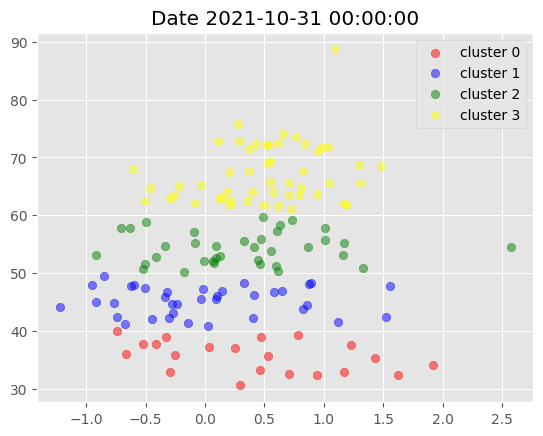

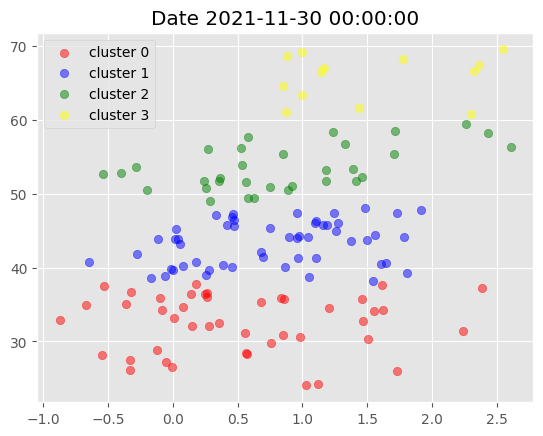

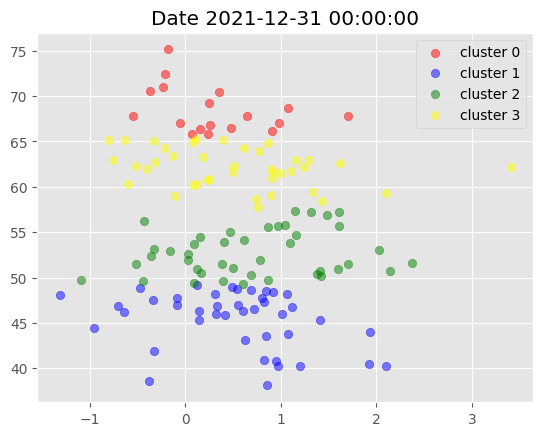

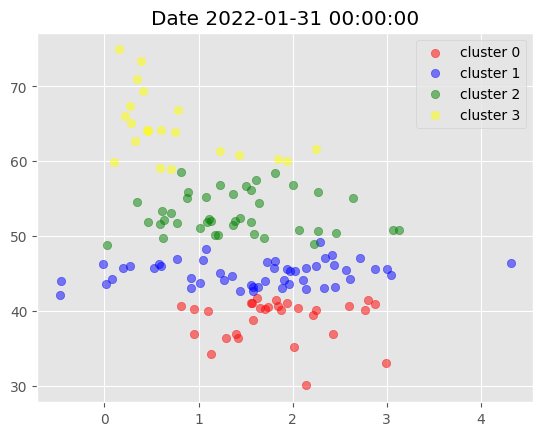

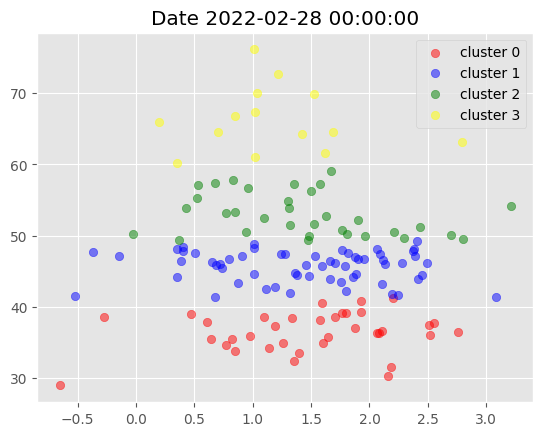

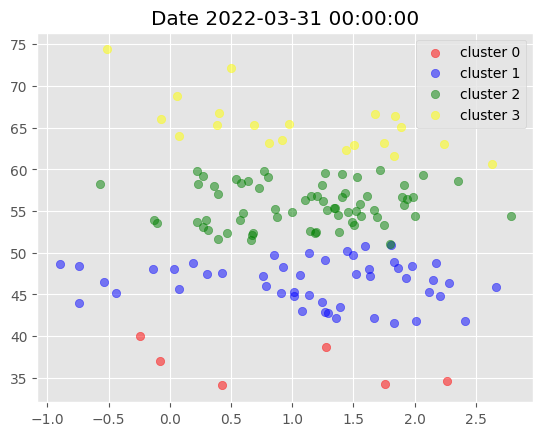

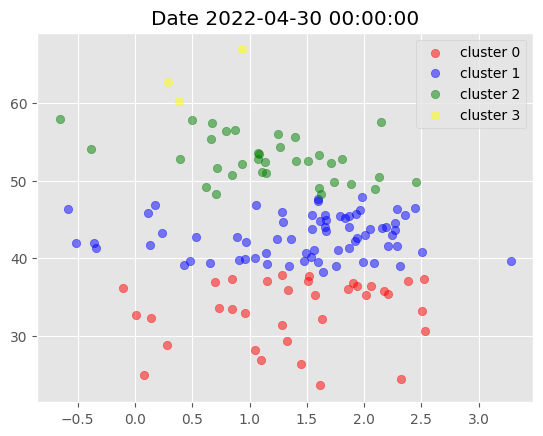

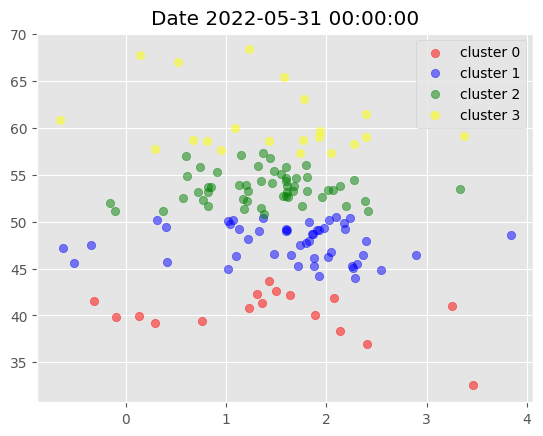

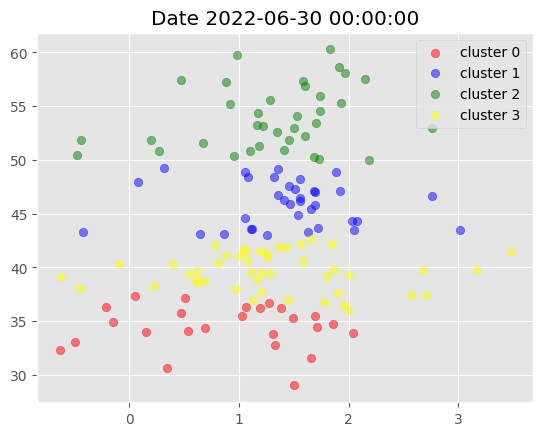

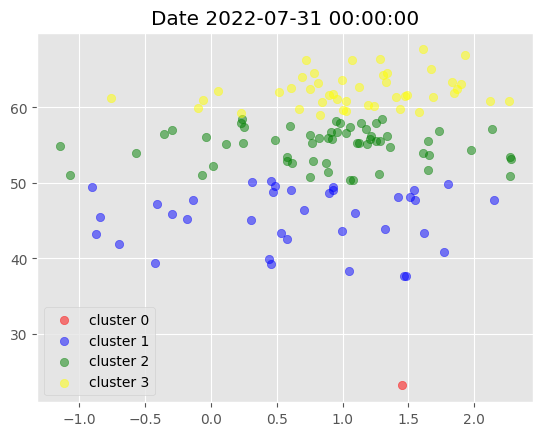

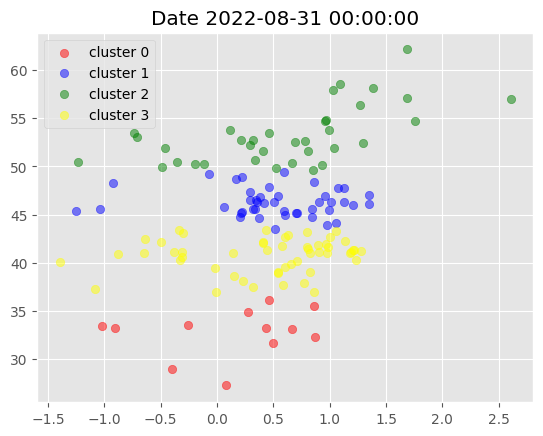

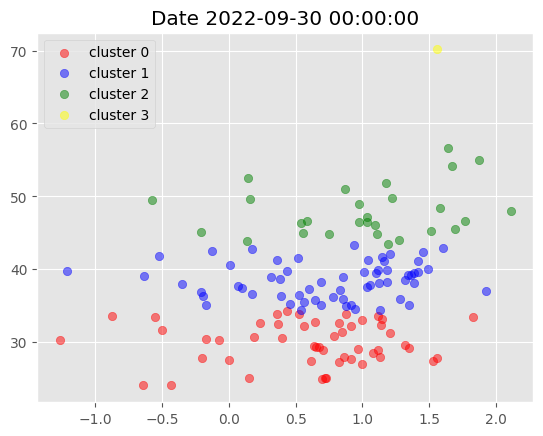

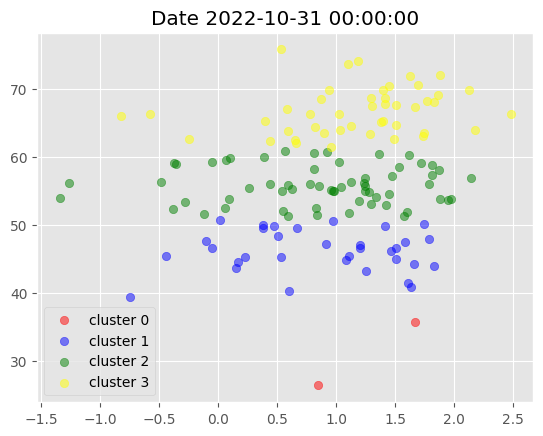

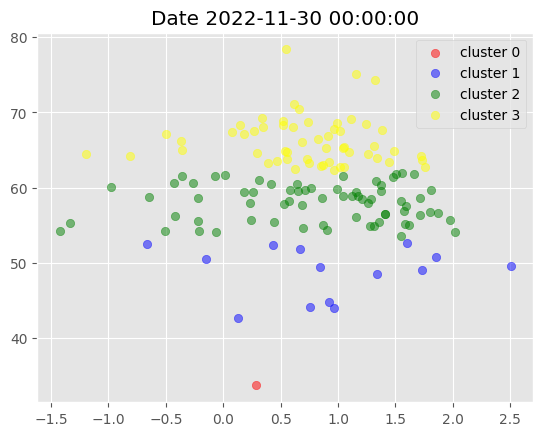

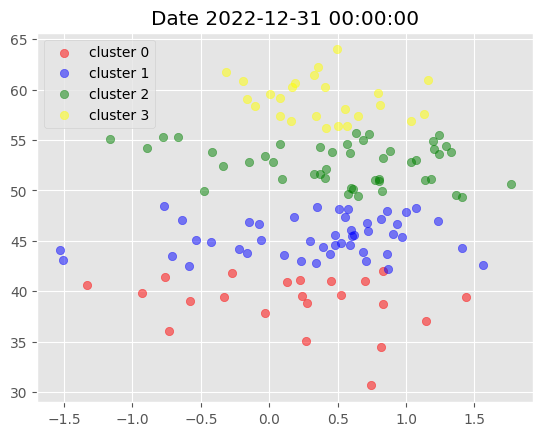

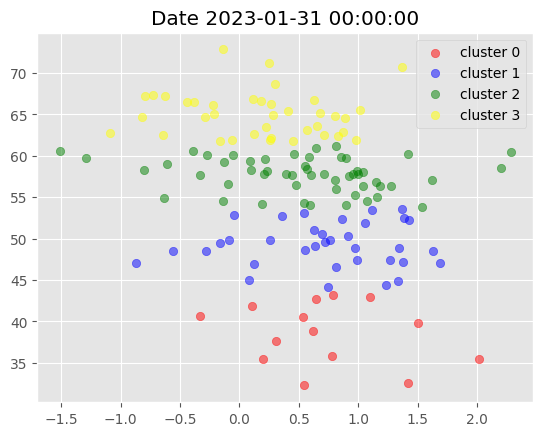

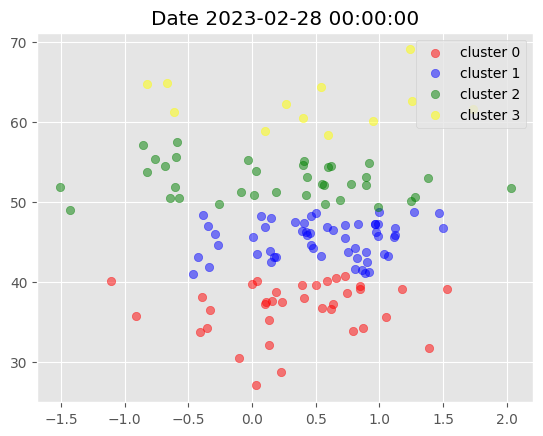

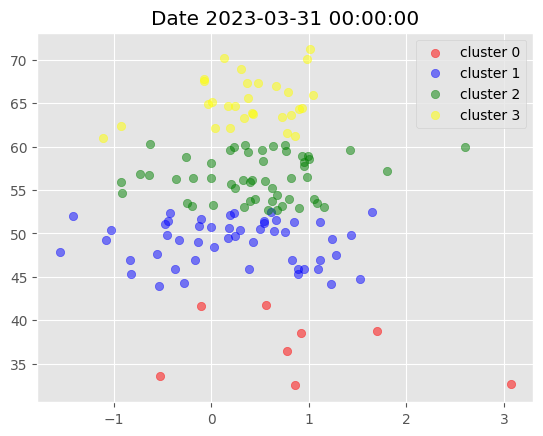

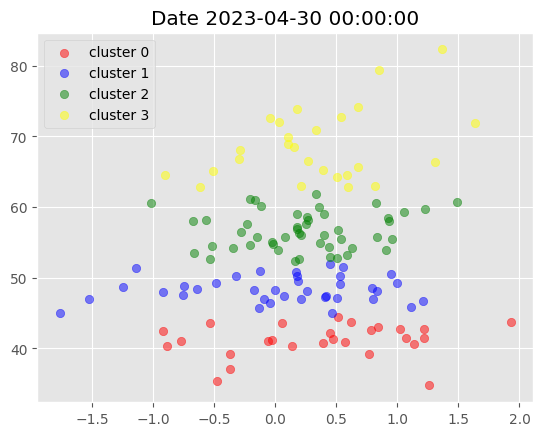

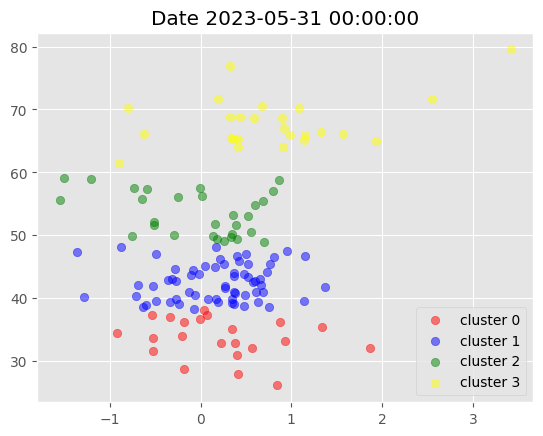

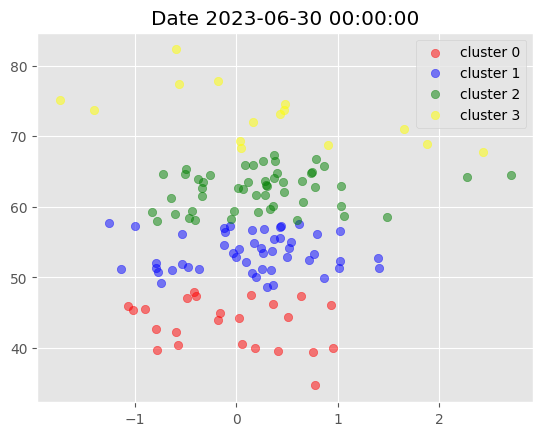

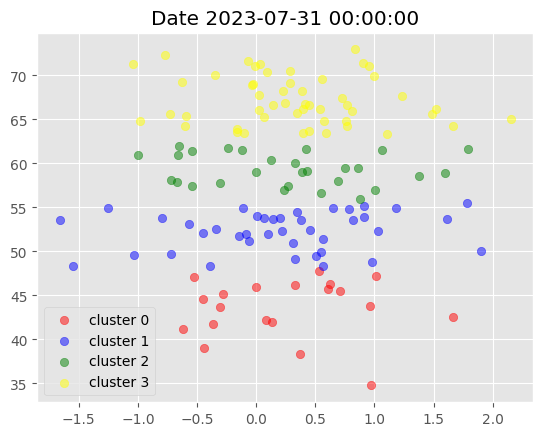

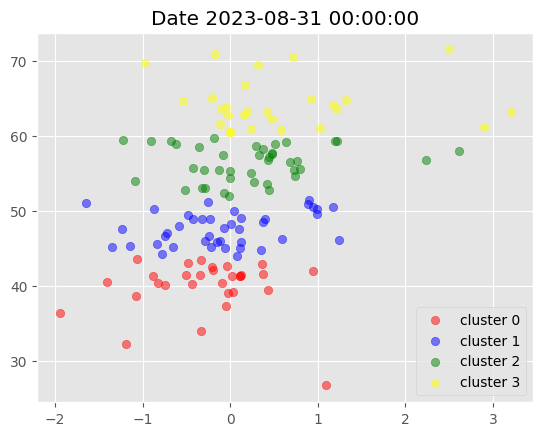

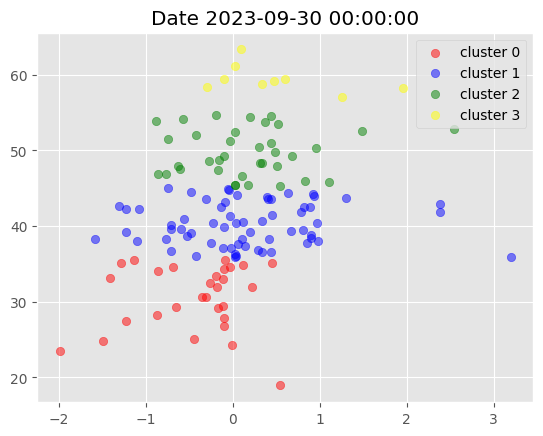

In [324]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0 )
    # print(g)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [299]:
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       tickers                                                             
2017-08-31 AAL      0.159033  3.936447  3.741600  3.839023         -0.000146   
           AAPL    -0.931918  3.678805  3.622255  3.650530         -0.001368   
           ABBV    -1.376602  4.022875  3.944742  3.983809         -0.032460   
           ABT     -1.157827  3.825750  3.773206  3.799478         -0.004445   
           ACN     -1.132070  4.773213  4.746614  4.759914         -0.004114   
...                      ...       ...       ...       ...               ...   
2023-09-30 VRTX     0.029799  5.879295  5.838959  5.859127          0.000037   
           VZ      -1.078816  3.516245  3.451862  3.484054         -0.001680   
           WFC     -0.558742  3.777782  3.697055  3.737418         -0.000110   
           WMT     -0.196381  4.019915  3.984976  4.002446         -0.000041   
           XOM      0.601335  4.767283  4.687091  4.727187         -0.000065   

                        macd        rsi  return_1m  return_2m  return_3m  \
date       tickers                                                         
2017-08-31 AAL     -1.736995  37.643881  -0.111206  -0.056118  -0.025279   
           AAPL     0.056940  65.282883   0.106999   0.069206   0.025287   
           ABBV     0.104924  68.425745   0.077099   0.023627   0.047937   
           ABT      0.071077  62.800400   0.035787   0.026514   0.039058   
           ACN     -0.079960  59.510459   0.015060   0.028224   0.016569   
...                      ...        ...        ...        ...        ...   
2023-09-30 VRTX     0.027907  52.406728   0.009617  -0.000923  -0.000208   
           VZ      -0.350386  42.222484  -0.056890  -0.016122  -0.033458   
           WFC     -0.282326  40.920278  -0.015500  -0.057917  -0.013554   
           WMT      0.399458  54.722532  -0.000676   0.010014   0.012354   
           XOM      1.400623  59.440187   0.046947   0.046139   0.030496   

                    return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       tickers                                                         
2017-08-31 AAL      -0.005218  -0.003427    0.018330  1.283585  1.294249   
           AAPL      0.031829   0.046264    0.038469  1.251192 -0.260362   
           ABBV      0.036617   0.027342    0.016730  0.503589  0.306475   
           ABT       0.022555   0.034961    0.018239  0.831293 -0.204126   
           ACN       0.012675   0.011280    0.012503  1.189505 -0.166015   
...                       ...        ...         ...       ...       ...   
2023-09-30 VRTX      0.018495   0.022140    0.016337  0.508293 -0.401241   
           VZ       -0.021495  -0.014100   -0.006158  0.302550 -0.212554   
           WFC       0.016712   0.000702    0.003255  1.136804  0.311860   
           WMT       0.017574   0.016553    0.020256  0.740245 -0.259787   
           XOM       0.012838   0.008747    0.027037  1.005255 -1.052323   

                         HML       RMW       CMA  cluster  
date       tickers                                         
2017-08-31 AAL      0.618906  0.525813  0.533136        2  
           AAPL    -0.589372  0.653504  0.349132        0  
           ABBV    -0.016543  0.132370  0.128977        0  
           ABT     -0.527067  0.239457  0.960225        0  
           ACN     -0.332383  0.259803  0.154884        3  
...                      ...       ...       ...      ...  
2023-09-30 VRTX    -0.489554  0.072229  0.958929        2  
           VZ       0.342720  0.318856  0.003003        3  
           WFC      2.009513 -0.406323 -1.469897        1  
           WMT     -0.522468 -0.125198  0.642473        2  
           XOM      1.707660 -0.675212 -0.285158        2  

[10362 rows x 19 columns]

### Apply pre-defined centroids

In [325]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

# The column of rsi values index : 6
initial_centroids[:,6] = target_rsi_values

initial_centroids


array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [327]:
data = data.drop('cluster', axis= 1)

In [328]:
# #Import the important library
from sklearn.cluster import KMeans

 #create a function to assign the cluster to the data
def get_clusters(df):
     df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
     return df

#Assign the cluster to the data
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data


atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       tickers                                                             
2017-08-31 AAL      0.159033  3.936447  3.741600  3.839023         -0.000146   
           AAPL    -0.931918  3.678805  3.622255  3.650530         -0.001368   
           ABBV    -1.376602  4.022875  3.944742  3.983809         -0.032460   
           ABT     -1.157827  3.825750  3.773206  3.799478         -0.004445   
           ACN     -1.132070  4.773213  4.746614  4.759914         -0.004114   
...                      ...       ...       ...       ...               ...   
2023-09-30 VRTX     0.029799  5.879295  5.838959  5.859127          0.000037   
           VZ      -1.078816  3.516245  3.451862  3.484054         -0.001680   
           WFC     -0.558742  3.777782  3.697055  3.737418         -0.000110   
           WMT     -0.196381  4.019915  3.984976  4.002446         -0.000041   
           XOM      0.601335  4.767283  4.687091  4.727187         -0.000065   

                        macd        rsi  return_1m  return_2m  return_3m  \
date       tickers                                                         
2017-08-31 AAL     -1.736995  37.643881  -0.111206  -0.056118  -0.025279   
           AAPL     0.056940  65.282883   0.106999   0.069206   0.025287   
           ABBV     0.104924  68.425745   0.077099   0.023627   0.047937   
           ABT      0.071077  62.800400   0.035787   0.026514   0.039058   
           ACN     -0.079960  59.510459   0.015060   0.028224   0.016569   
...                      ...        ...        ...        ...        ...   
2023-09-30 VRTX     0.027907  52.406728   0.009617  -0.000923  -0.000208   
           VZ      -0.350386  42.222484  -0.056890  -0.016122  -0.033458   
           WFC     -0.282326  40.920278  -0.015500  -0.057917  -0.013554   
           WMT      0.399458  54.722532  -0.000676   0.010014   0.012354   
           XOM      1.400623  59.440187   0.046947   0.046139   0.030496   

                    return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       tickers                                                         
2017-08-31 AAL      -0.005218  -0.003427    0.018330  1.283585  1.294249   
           AAPL      0.031829   0.046264    0.038469  1.251192 -0.260362   
           ABBV      0.036617   0.027342    0.016730  0.503589  0.306475   
           ABT       0.022555   0.034961    0.018239  0.831293 -0.204126   
           ACN       0.012675   0.011280    0.012503  1.189505 -0.166015   
...                       ...        ...         ...       ...       ...   
2023-09-30 VRTX      0.018495   0.022140    0.016337  0.508293 -0.401241   
           VZ       -0.021495  -0.014100   -0.006158  0.302550 -0.212554   
           WFC       0.016712   0.000702    0.003255  1.136804  0.311860   
           WMT       0.017574   0.016553    0.020256  0.740245 -0.259787   
           XOM       0.012838   0.008747    0.027037  1.005255 -1.052323   

                         HML       RMW       CMA  cluster  
date       tickers                                         
2017-08-31 AAL      0.618906  0.525813  0.533136        0  
           AAPL    -0.589372  0.653504  0.349132        3  
           ABBV    -0.016543  0.132370  0.128977        3  
           ABT     -0.527067  0.239457  0.960225        3  
           ACN     -0.332383  0.259803  0.154884        2  
...                      ...       ...       ...      ...  
2023-09-30 VRTX    -0.489554  0.072229  0.958929        2  
           VZ       0.342720  0.318856  0.003003        1  
           WFC      2.009513 -0.406323 -1.469897        1  
           WMT     -0.522468 -0.125198  0.642473        2  
           XOM      1.707660 -0.675212 -0.285158        3  

[10362 rows x 19 columns]

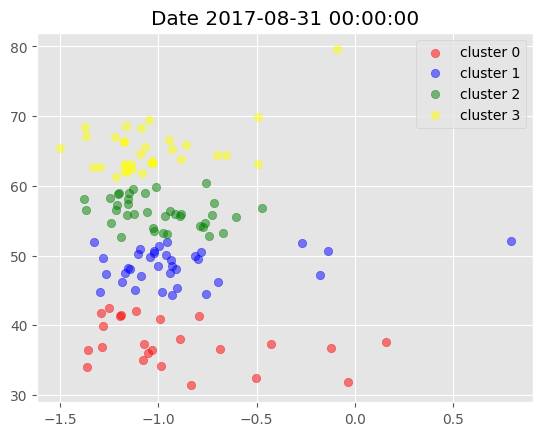

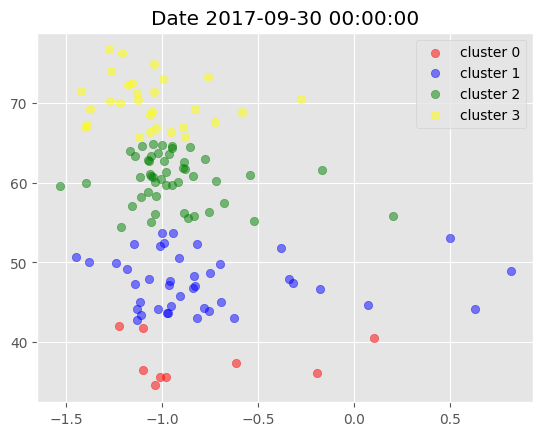

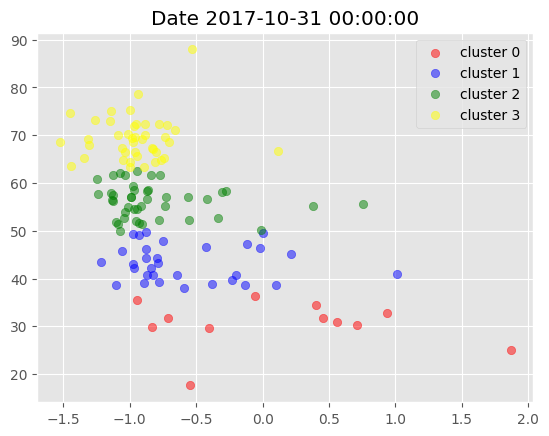

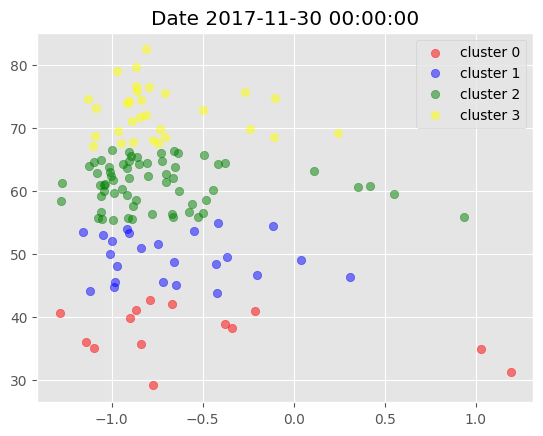

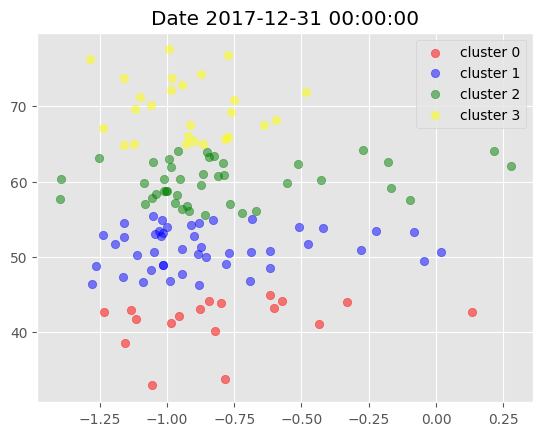

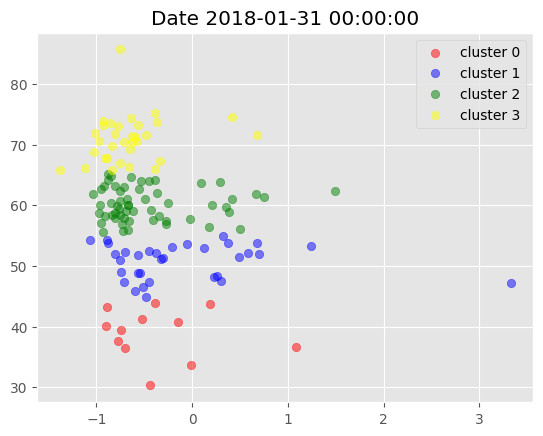

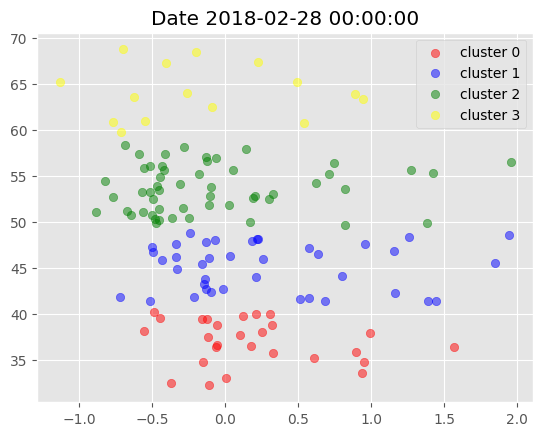

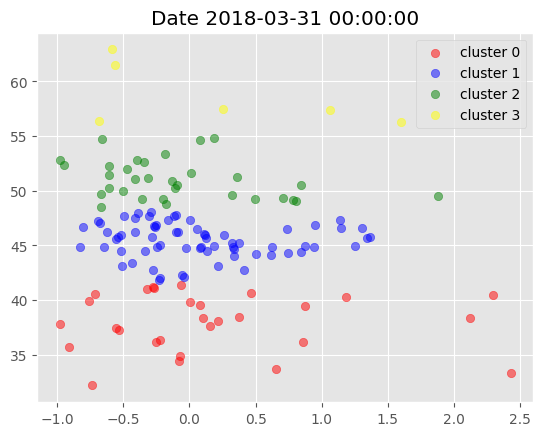

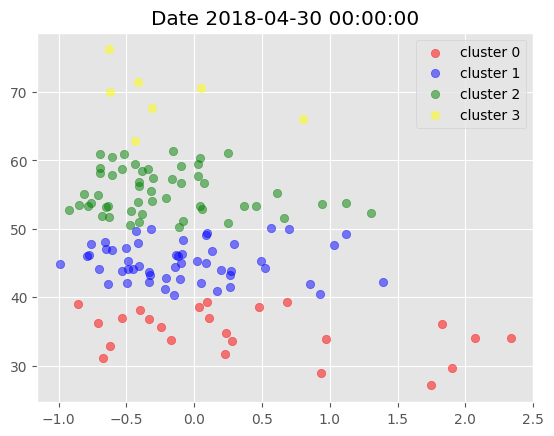

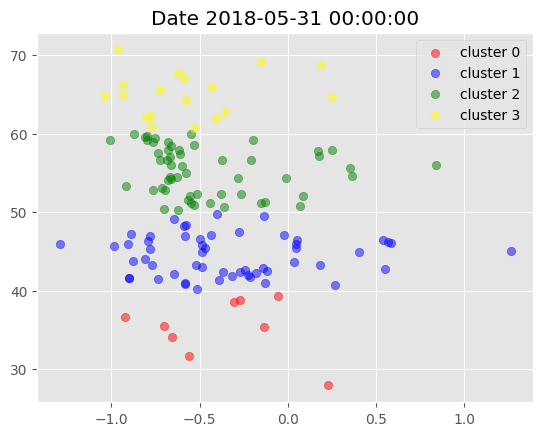

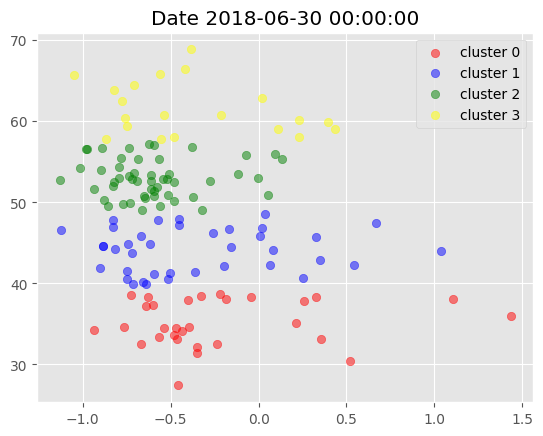

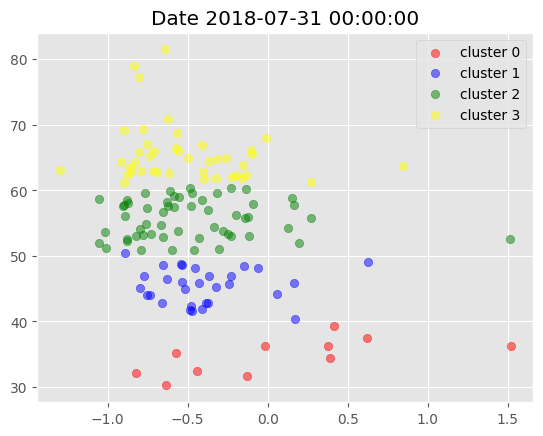

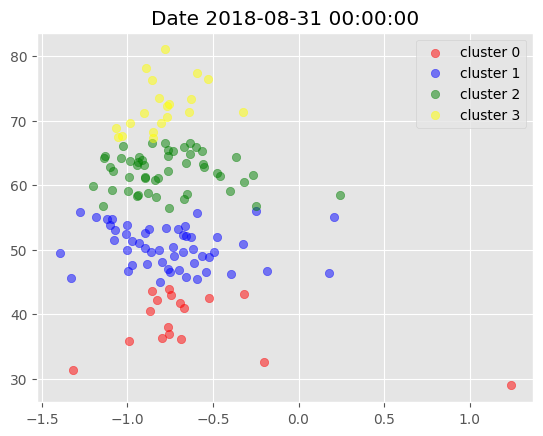

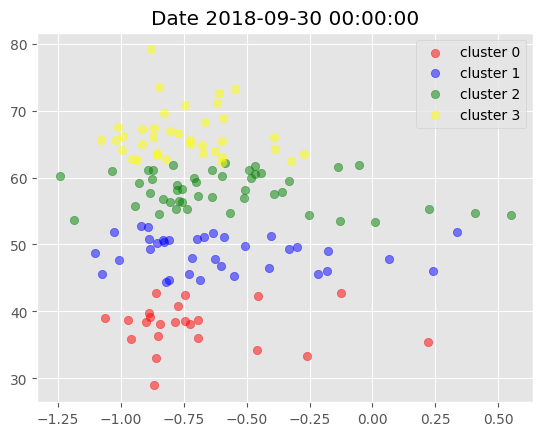

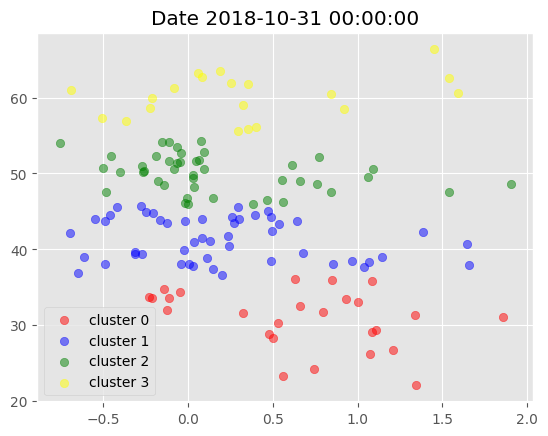

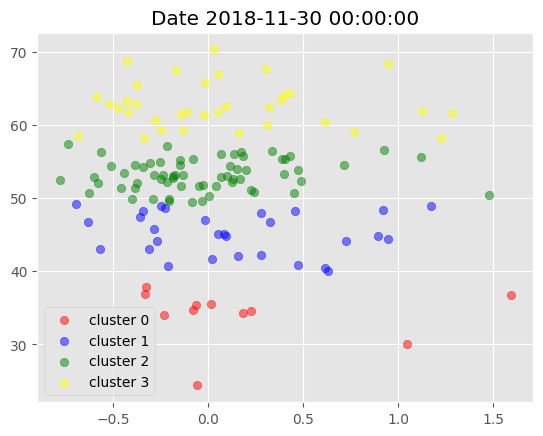

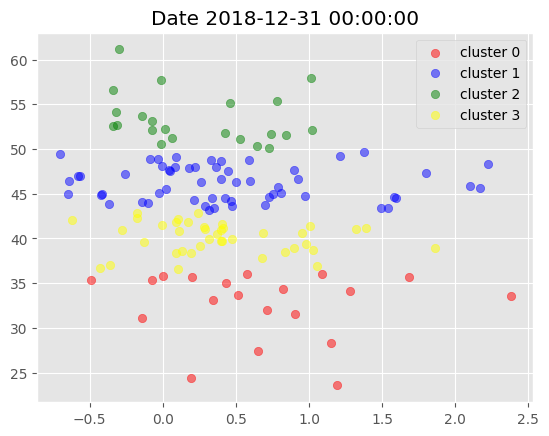

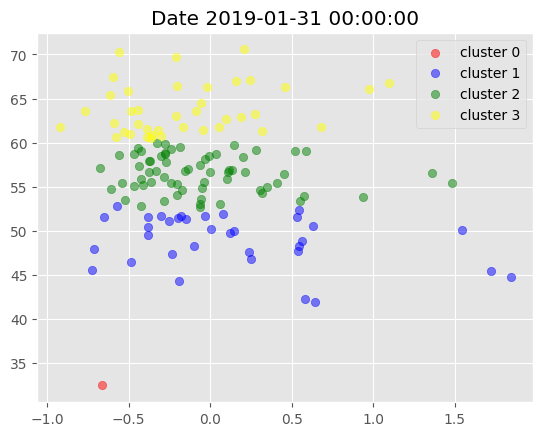

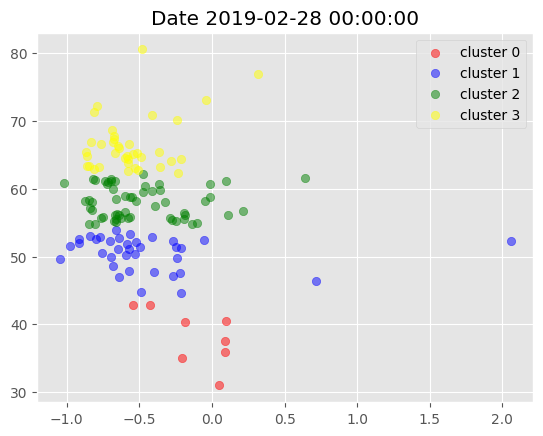

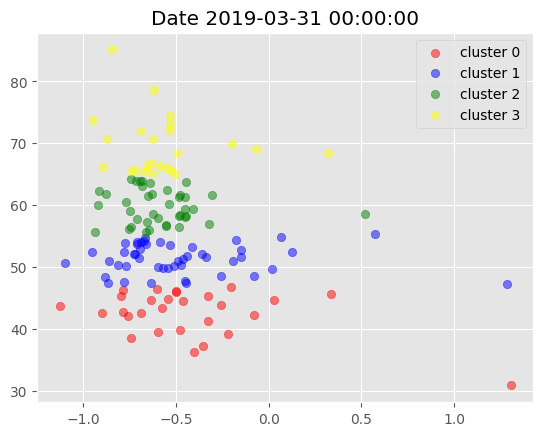

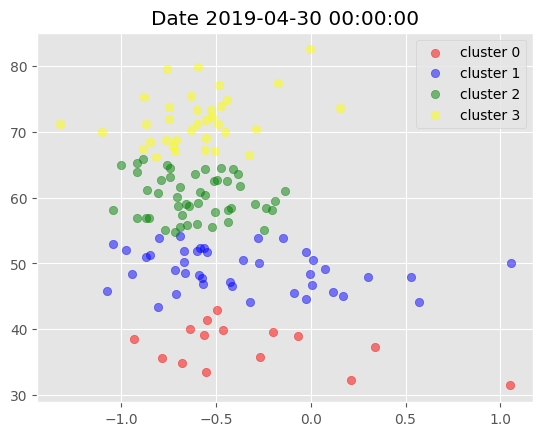

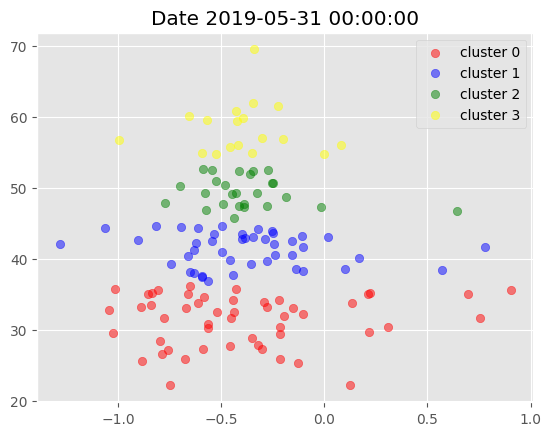

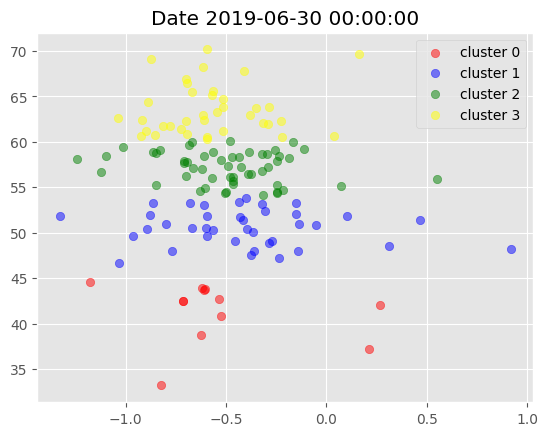

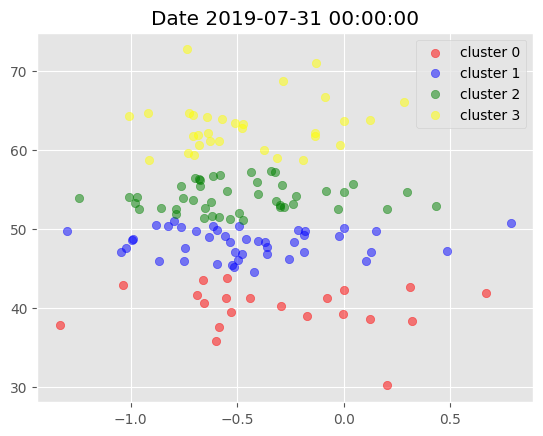

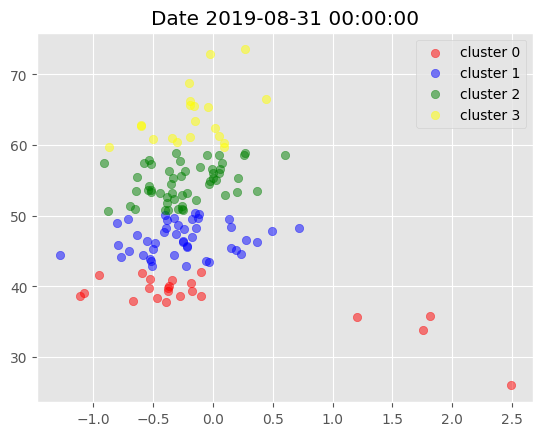

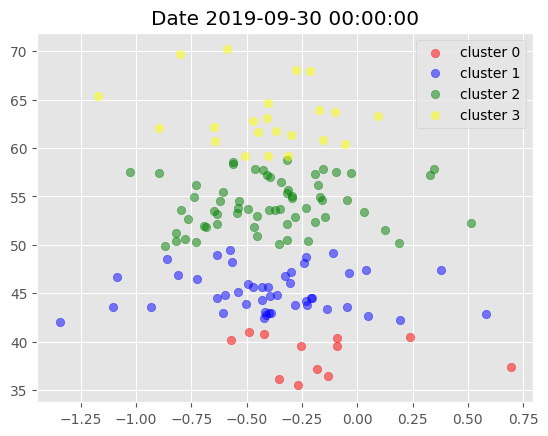

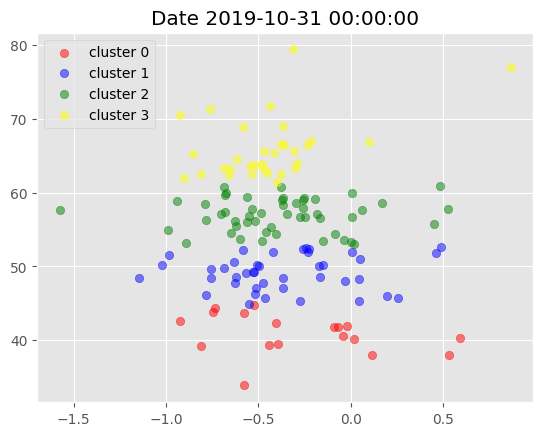

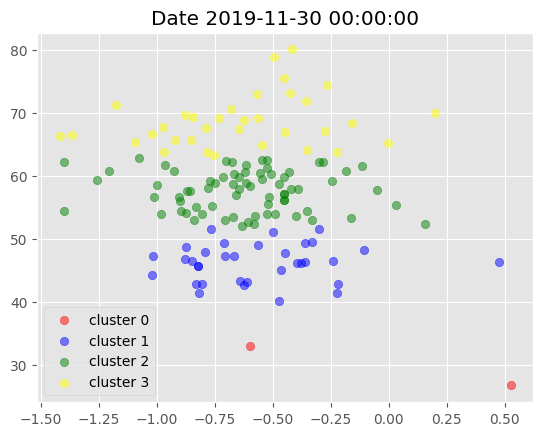

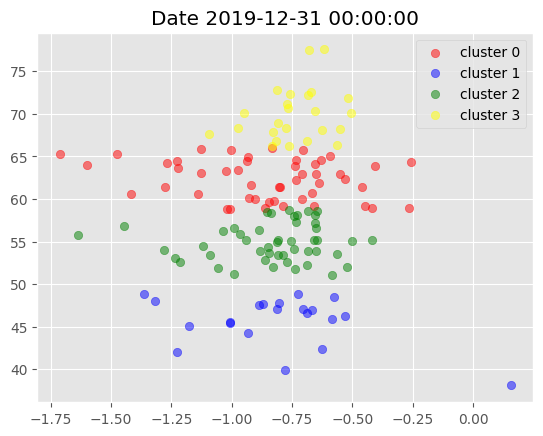

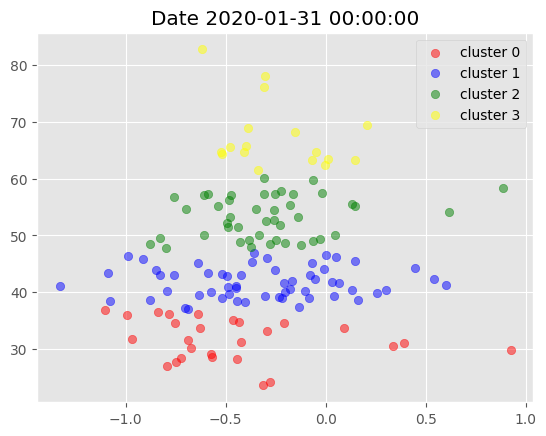

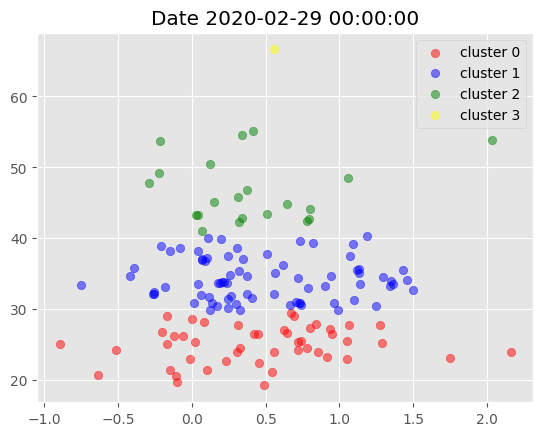

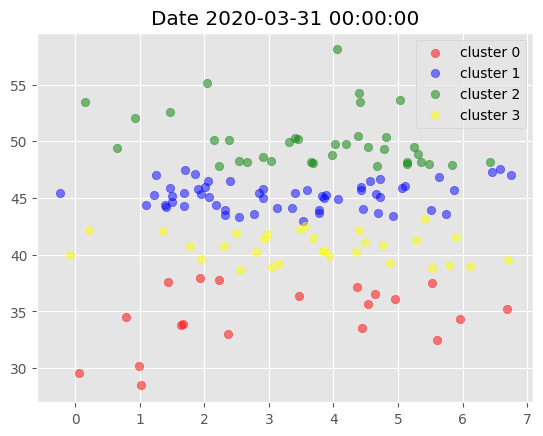

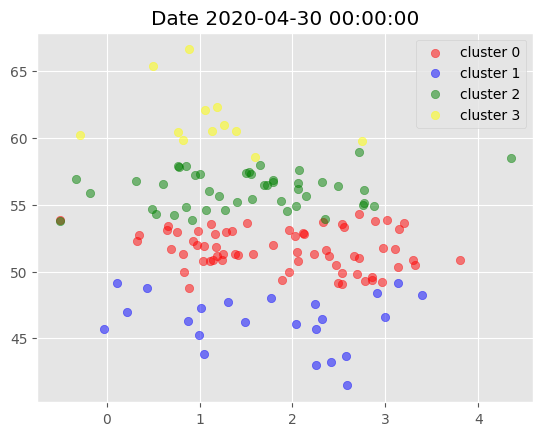

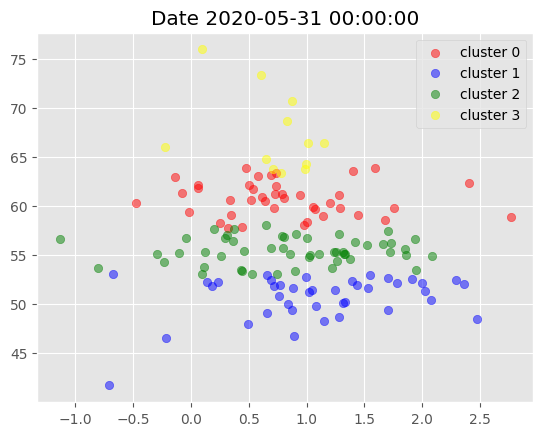

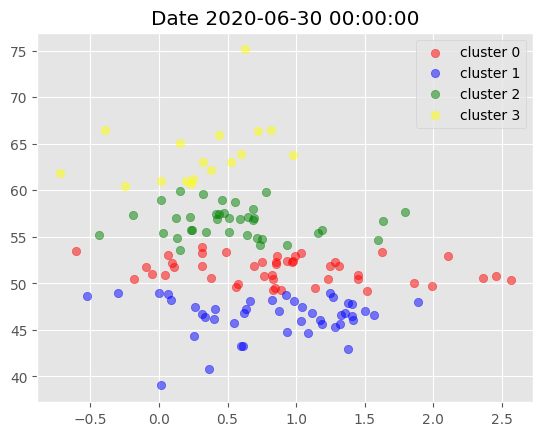

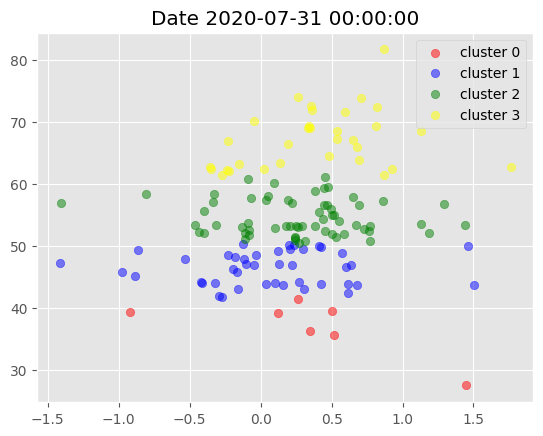

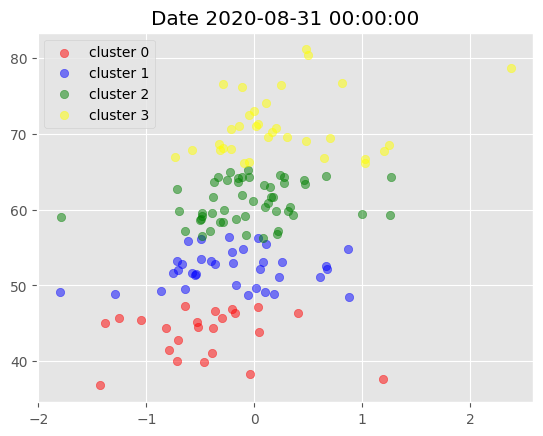

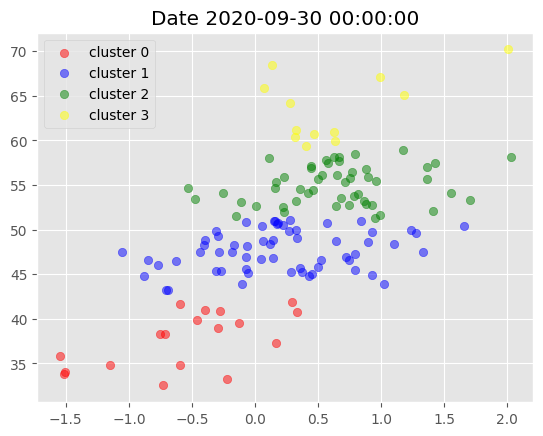

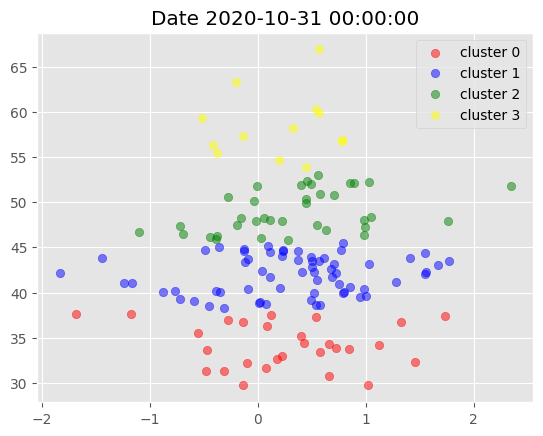

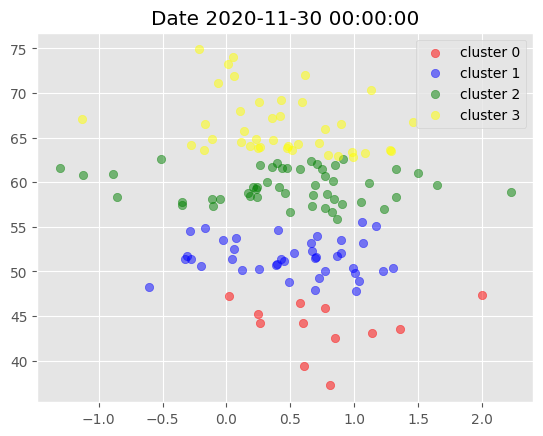

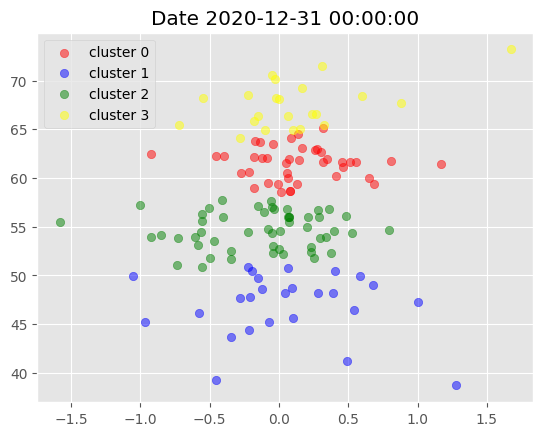

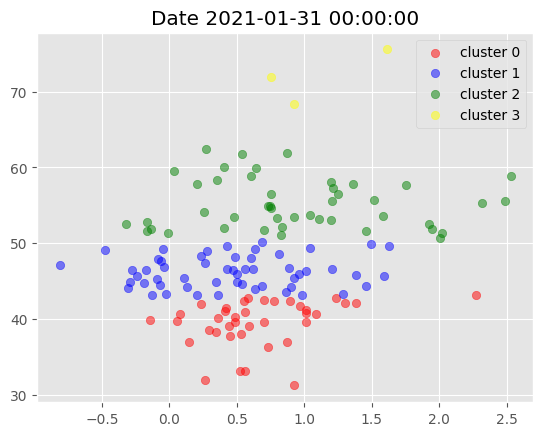

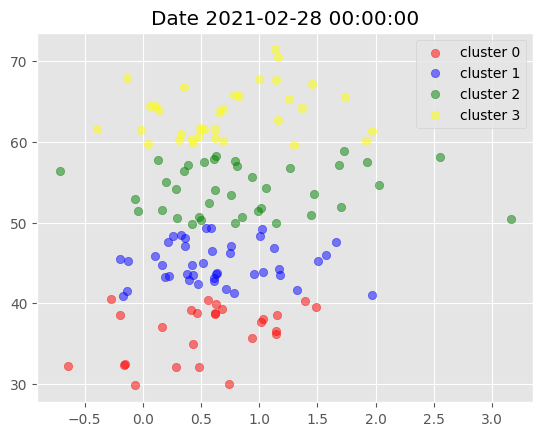

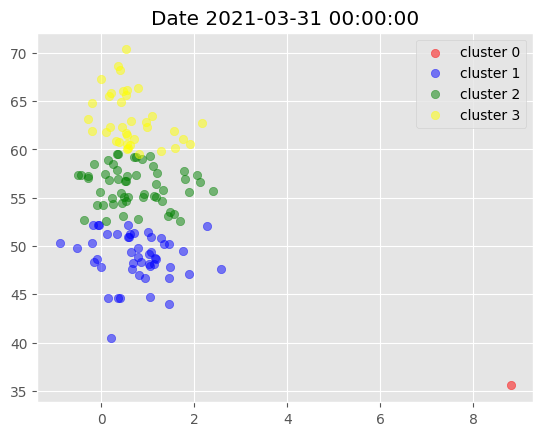

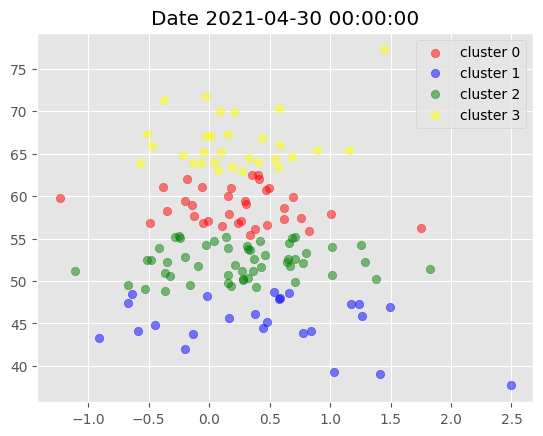

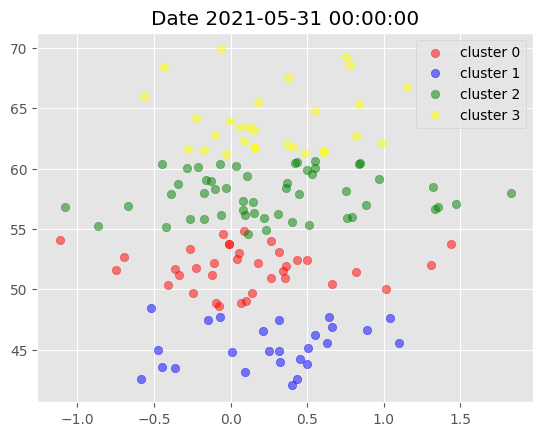

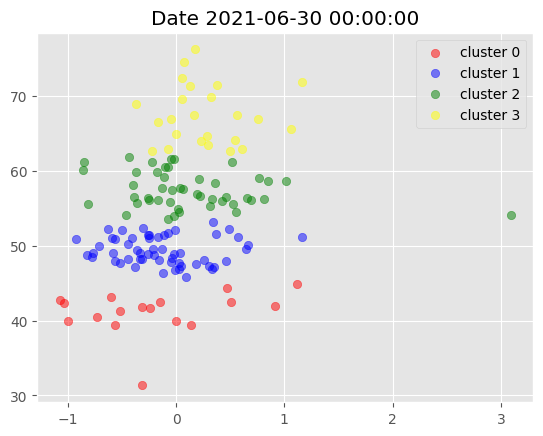

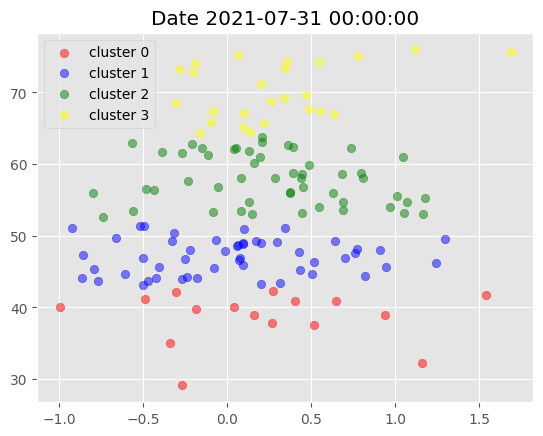

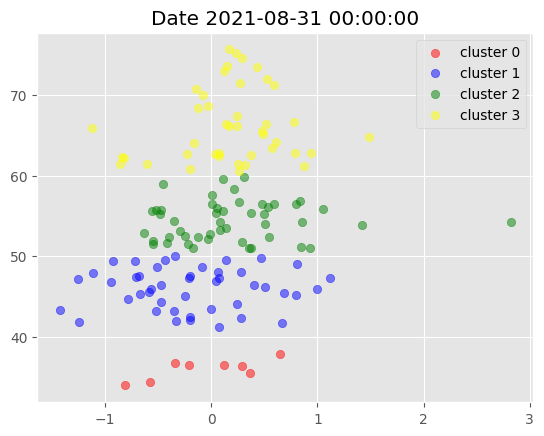

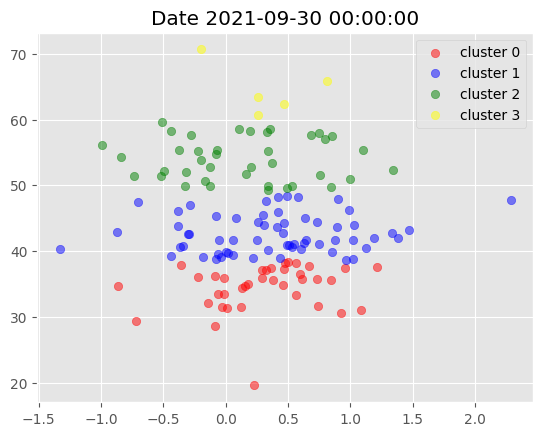

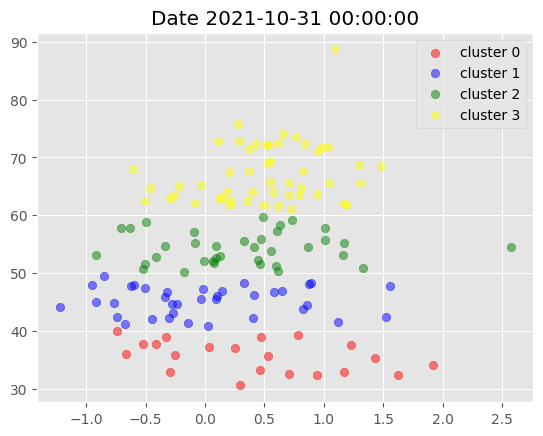

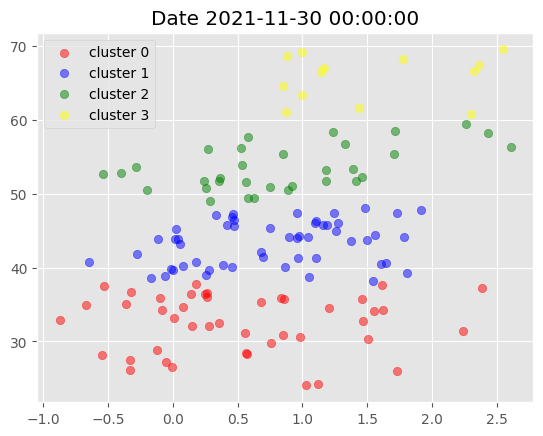

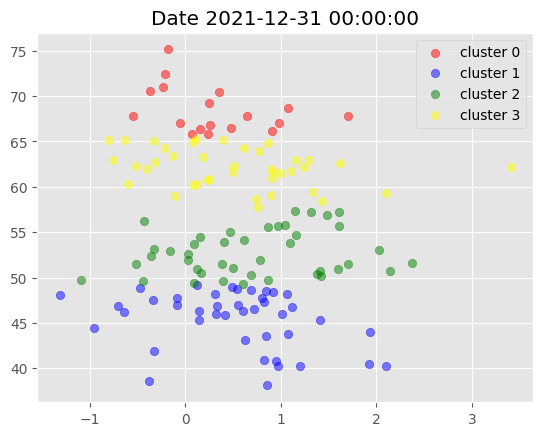

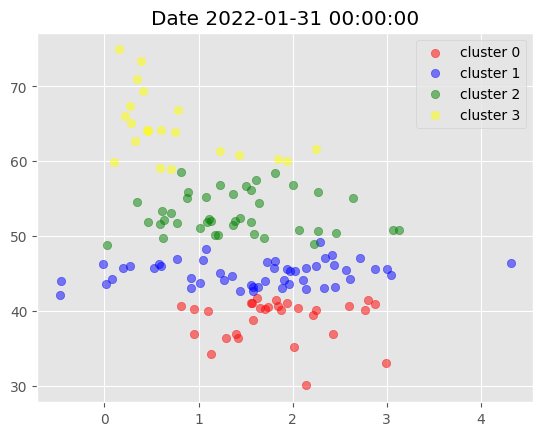

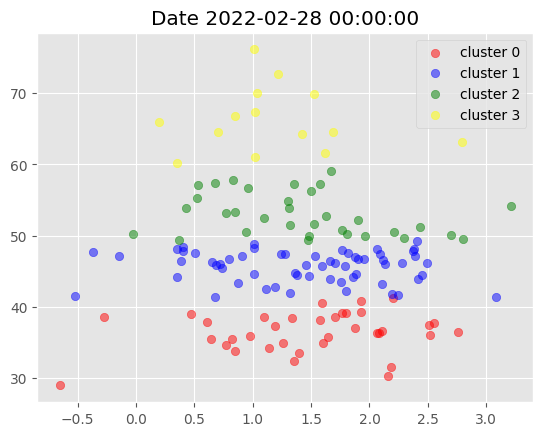

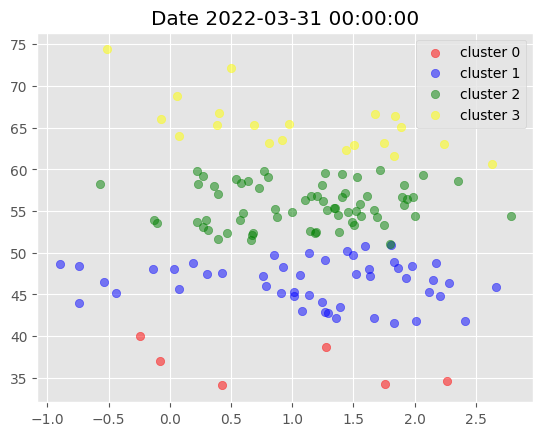

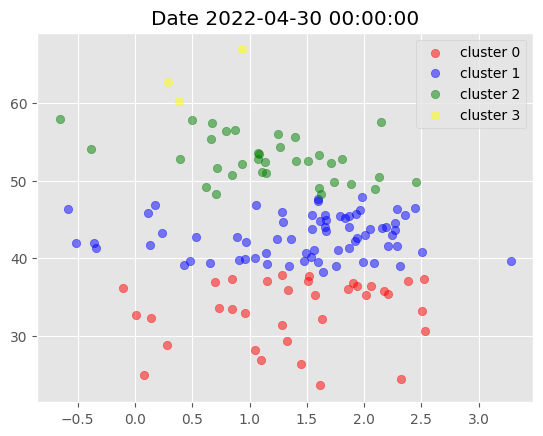

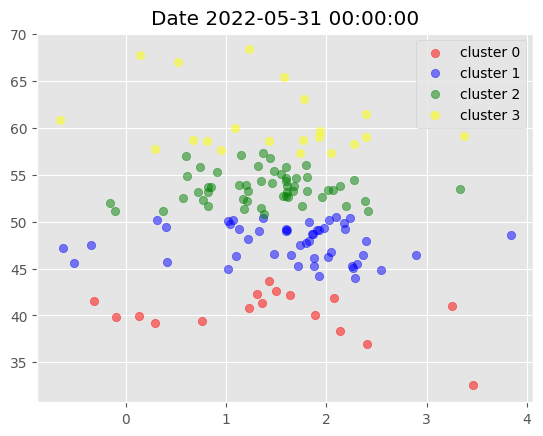

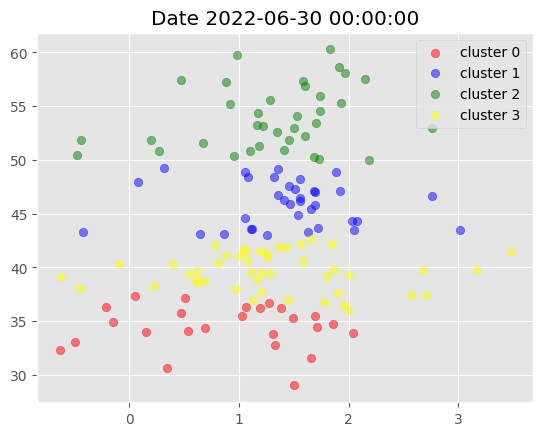

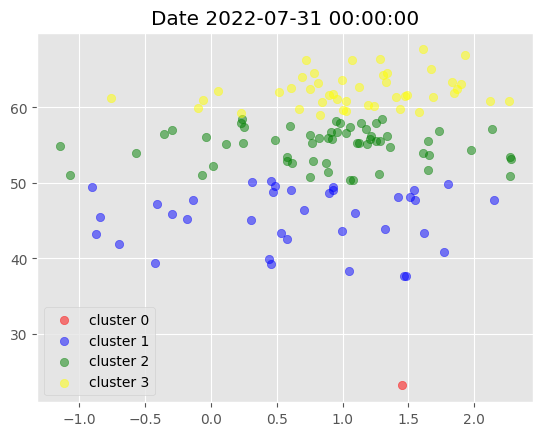

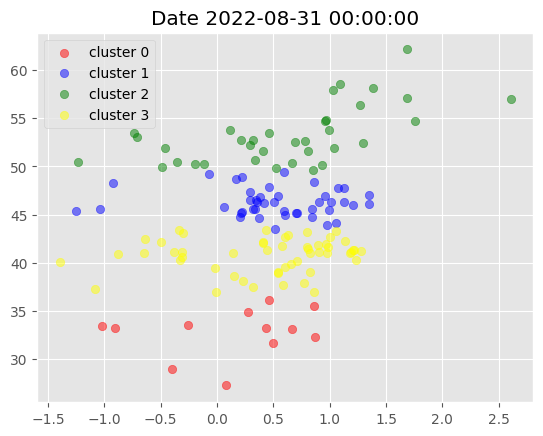

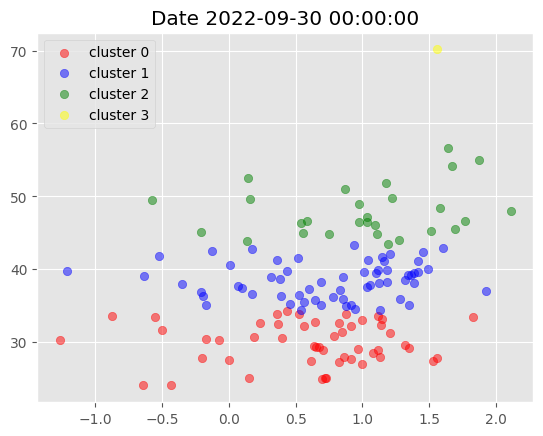

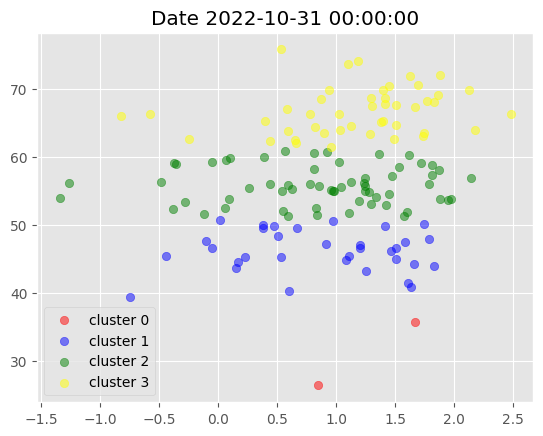

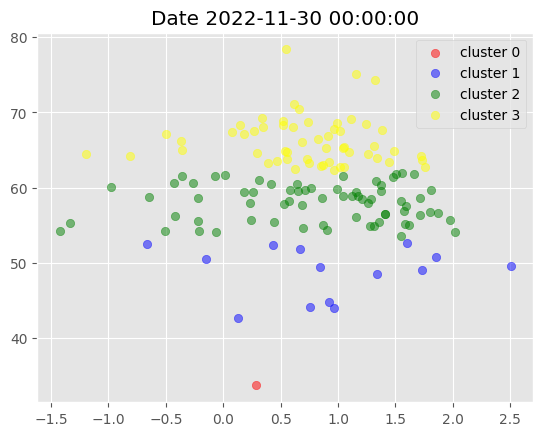

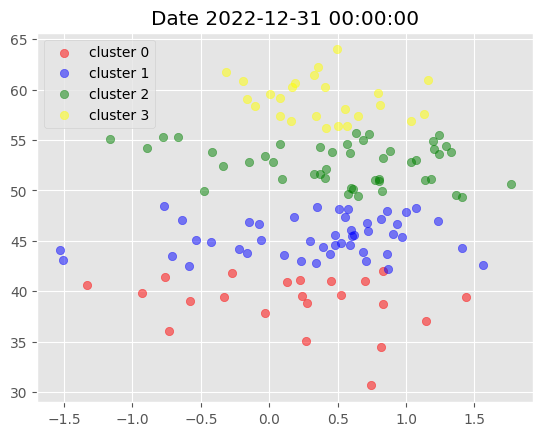

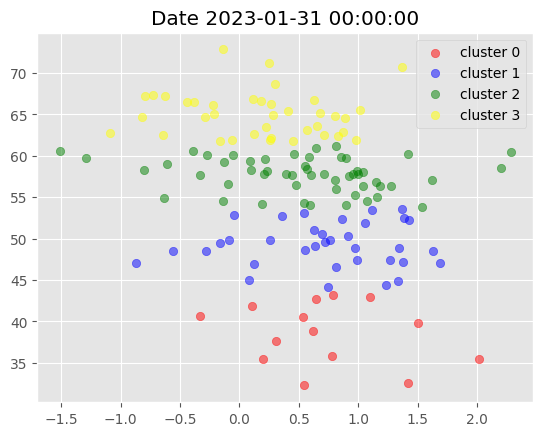

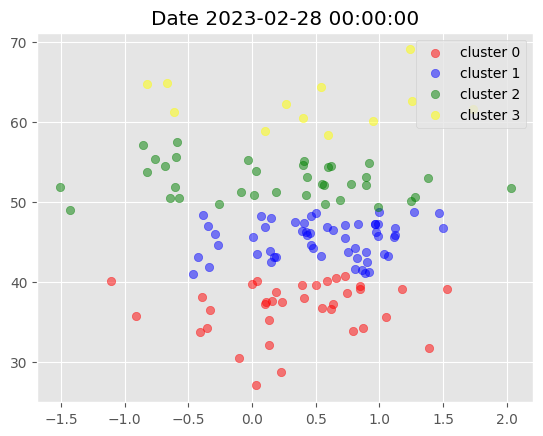

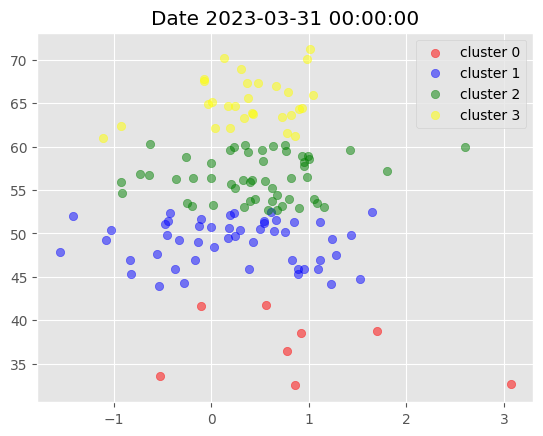

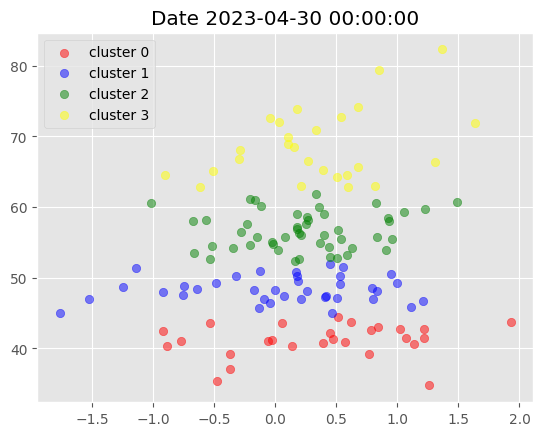

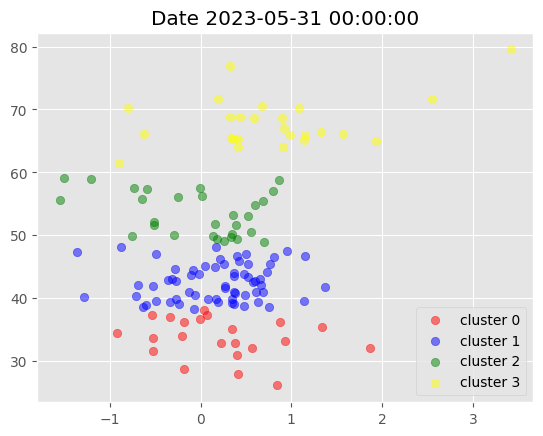

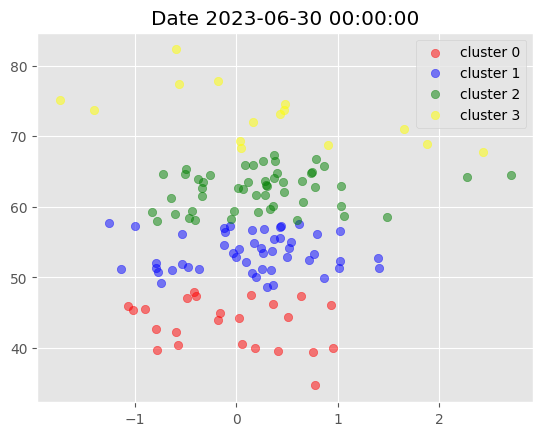

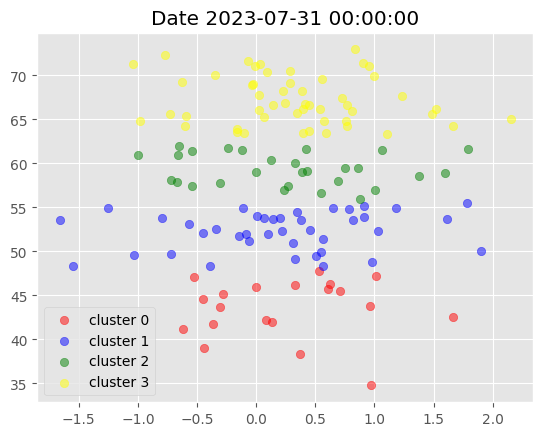

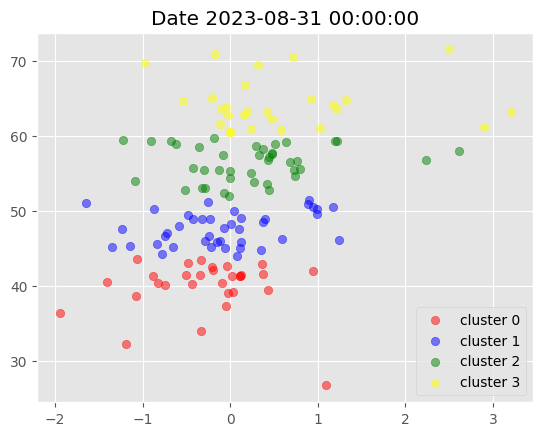

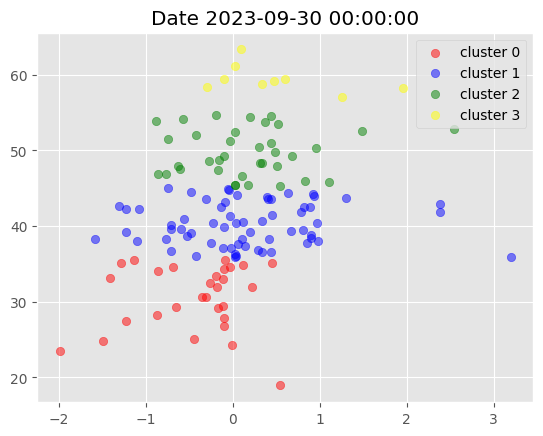

In [329]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0 )
    plt.title(f'Date {i}')
    plot_clusters(g)

## 7. For each month, select assets based on the cluster and form a porfolio based on Efficient Frontier max sharpe ratio optimization
 1. Filter the stocks correspond to the cluster that we choose based on our hypothesis
 2. Hyporthesis: RSI around 70 centroid is good momentum, which means it would perform well in the next month
    As we observe from previous plot, cluster 3 is around 60 - 70 (which is what we look for)

In [356]:
#Fliter out stock in cluster 3
filtered_df = data[data['cluster']==3]

#reset index of ticker
filtered_df = filtered_df.reset_index(level = 1)

#move index to one day in the future
filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date','tickers'])
#set the df to be multi-index
dates = filtered_df.index.get_level_values('date').unique().tolist()
#Create a dictionary format: {next_month: [list_stock_tobe_invest]}
fixed_dates = {}

for d in dates:
     fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-09-01': ['AAPL',
  'ABBV',
  'ABT',
  'ADBE',
  'AMGN',
  'BA',
  'BIIB',
  'BMY',
  'BRK-B',
  'CAT',
  'CCL',
  'CHTR',
  'CRM',
  'DD',
  'DLTR',
  'EA',
  'GILD',
  'GM',
  'HUM',
  'ISRG',
  'LMT',
  'MA',
  'MCD',
  'META',
  'MSFT',
  'NEE',
  'NXPI',
  'PFE',
  'PG',
  'PYPL',
  'TMO',
  'UNH',
  'V'],
 '2017-10-01': ['ABBV',
  'AMAT',
  'AXP',
  'BA',
  'BMY',
  'C',
  'CAT',
  'COP',
  'CVX',
  'DLTR',
  'EOG',
  'F',
  'FDX',
  'GM',
  'HAL',
  'HD',
  'INTC',
  'MAR',
  'MET',
  'MU',
  'OXY',
  'SCHW',
  'SLB',
  'TXN',
  'UNP',
  'UPS',
  'VLO',
  'WFC',
  'XOM'],
 '2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '

## Define portfolio optimization function
- Define function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio
- Optimize the weights of give portforlio by supply the last year prices to the funciton
- Apply single stock weight bounds constrain for diversifivcation ()

In [365]:
!pip install PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [30 lines of output]
  + meson setup C:\Users\nguye\AppData\Local\Temp\pip-install-6_f2tnr9\scs_22e933c6f41a4e59814ad842e8f3a51a C:\Users\nguye\AppData\Local\Temp\pip-install-6_f2tnr9\scs_22e933c6f41a4e59814ad842e8f3a51a\.mesonpy-geq70aan -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\nguye\AppData\Local\Temp\pip-install-6_f2tnr9\scs_22e933c6f41a4e59814ad842e8f3a51a\.mesonpy-geq70aan\meson-python-native-file.ini
  The Meson build system
  Version: 1.5.1
  Source dir: C:\Users\nguye\AppData\Local\Temp\pip-install-6_f2tnr9\scs_22e933c6f41a4e59814ad842e8f3a51a
  Build dir: C:\Users\nguye\AppData\Local\Temp\pip-install-6_f2tnr9\scs_22e933c6f41a4e59814ad842e8f3a51a\.mesonpy-geq70aan
  Build type: native build
  Project name: scs
  Project version: undefined
  C compiler for the host machine: gcc (gcc 6.3.0 "gcc (MinGW.org GCC-6.3.0-1) 6.

  Using cached pyportfolioopt-1.5.2-py3-none-any.whl (61 kB)
  Using cached cvxpy-1.3.4.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached ecos-2.0.14-cp37-cp37m-win_amd64.whl (71 kB)
  Using cached scs-3.2.6.tar.gz (1.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [30 lines of output]
  + meson setup C:\Users\nguye\AppData\Local\Temp\pip-install-rhxge39c\scs_58d0df3283f44849937470d8d46d09b6 C:\Users\nguye\AppData\Local\Temp\pip-install-rhxge39c\scs_58d0df3283f44849937470d8d46d09b6\.mesonpy-3g0ilqfd -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\nguye\AppData\Local\Temp\pip-install-rhxge39c\scs_58d0df3283f44849937470d8d46d09b6\.mesonpy-3g0ilqfd\meson-python-native-file.ini
  The Meson build system
  Version: 1.5.1
  Source dir: C:\Users\nguye\AppData\Local\Temp\pip-install-rhxge39c\scs_58d0df3283f44849937470d8d46d09b6
  Build dir: C:\Users\nguye\AppData\Local\Temp\pip-install-rhxge39c\scs_58d0df3283f44849937470d8d46d09b6\.mesonpy-3g0ilqfd
  Build type: native build
  Project name: scs
  Project version: undefined
  C compiler for the host machine: gcc (gcc 6.3.0 "gcc (MinGW.org GCC-6.3.0-1) 6.

  Using cached pyportfolioopt-1.5.2-py3-none-any.whl (61 kB)
  Using cached cvxpy-1.3.4.tar.gz (1.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached ecos-2.0.14-cp37-cp37m-win_amd64.whl (71 kB)
  Using cached osqp-0.6.7.post1-cp37-cp37m-win_amd64.whl (293 kB)
  Using cached scs-3.2.6.tar.gz (1.5 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyprojec

In [425]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound = 0):
    returns = expected_returns.mean_historical_return(prices = prices,
                                                    frequency = 252) #252 is one year of trading data
    cov = risk_models.sample_cov(prices = prices,
                                frequency = 252)

    ef = EfficientFrontier(expected_returns = returns,
                           cov_matrix = cov,
                           weight_bounds = (lower_bound,.1),
                           solver = 'SCS')
    weights = ef.max_sharpe()

    return ef.clean_weights()

- Download fresh daily prices data for short listed stock

In [367]:
stocks = data.index.get_level_values('tickers').unique().tolist()

new_df = yf.download(tickers = stocks,
                    start = data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                    end = data.index.get_level_values('date').unique()[-1])


[*********************100%%**********************]  156 of 156 completed


In [368]:
new_df

Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-08-31  34.989571   24.494835   45.408325  36.298473  100.967094   
2016-09-01  34.931728   24.640284   45.358730  36.540333  101.019768   
2016-09-02  35.211258   24.871149   45.422489  36.358948  101.546562   
2016-09-06  35.625729   24.864220   45.769600  36.419407  101.283157   
2016-09-07  37.351124   25.016592   46.024624  36.194809  101.072449   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.386337  148.897141  95.484749  311.950897   
2023-09-26  12.700000  171.282562  148.184677  94.270012  305.672333   
2023-09-27  12.610000  169.758591  147.433685  93.584259  309.382385   
2023-09-28  12.920000  170.017578  146.586441  96.121513  295.988770   
2023-09-29  12.810000  170.535538  143.515106  94.877373  302.227966   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-08-31  102.309998   75.714455   67.400002  48.667206   27.301676  ...   
2016-09-01  102.900002   76.405746   67.370003  48.325569   27.713396  ...   
2016-09-02  103.570000   76.203415   68.010002  48.691605   27.466364  ...   
2016-09-06  103.500000   75.756615   67.690002  48.358105   27.429768  ...   
2016-09-07  103.000000   76.290894   68.599998  48.293022   27.365721  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  235.844086  205.669998  61.170826  135.818924  ...   
2023-09-26  506.299988  233.112457  201.660004  60.314251  133.323090  ...   
2023-09-27  502.600006  238.408691  202.279999  60.068111  134.297562  ...   
2023-09-28  504.670013  239.076843  207.889999  60.333942  137.439713  ...   
2023-09-29  509.899994  236.394348  206.910004  59.664444  137.668427  ...   

Price        Volume                                                           \
Ticker            V      VLO    VRTX        VZ       WBA       WDC       WFC   
Date                                                                           
2016-08-31  7386100  5006200  797500  10390500   3282700   3336500  24533600   
2016-09-01  6240600  5281500  966600   9988800   3296100   3015100  17017100   
2016-09-02  6408900  4872900  843100  13275300   3029600   2820600  12684000   
2016-09-06  8140400  3554000  877600  17235600   3726000   4514100  21832200   
2016-09-07  9304700  4613600  928300  10612300   3315900  18607100  12437300   
...             ...      ...     ...       ...       ...       ...       ...   
2023-09-25  5921600  3241900  698100  17616900   6891000   2685900  10624000   
2023-09-26  6193200  4936800  633600  18841600   7570500   3571100  15219400   
2023-09-27  6006700  3644000  860600  22083500  10182900   2547800  11815500   
2023-09-28  4203900  3587300  578900  18772100   7291500   3282000  12454600   
2023-09-29  6044200  4302200  896800  19759400  25659100   2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-08-31  18934800  2146500  12491400  
2016-09-01  35284200  6805000   8434700  
2016-09-02  24248700  3025400   7099600  
2016-09-06  28712700  2029900   9851200  
2016-09-07  28854900  2617000   7470400  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1782 rows x 936 columns]

- Calculate the daily return for each stock
- Loop through each month, select the stocks for each month and calculate the weights for the next month
- If the maximum sharpe ratio optimization falls for a given month, apply equally-weighted weights
- Calculate each day portolio return


In [454]:
# Create return dataframe
# returns_dataframe = np.log(new_df['Adj Close']).diff()

#Create porfortlio dataframe
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        #end_date: end of the month of start_date
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    
        cols = fixed_dates[start_date]
       
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months = 12)).strftime('%Y-%m-%d')
        
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days = 1)).strftime('%Y-%m-%d')
    
        #Create optimization dataframe
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        #calculate the weight for the stcoks: inout price of one year prioir of the stock
        success = False
        try:
             #Case the function is optimize
            weights = optimize_weights(prices=optimization_df,
                                      lower_bound =  round(1/(len(optimization_df.columns)*2),3))
            weights = pd.DataFrame(weights, index = pd.Series(0))

            success = True
        except:
            print(f"Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights")

        #Case the function cant be optimize
        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                             index=optimization_df.columns.tolist(),
                                             columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]
    
        #Merging the weight with the return
        temp_df = temp_df.stack().to_frame('return').reset_index(level = 0)\
                    .merge(weights.stack().to_frame('weight').reset_index(level = 0, drop = True),
                           left_index = True,
                           right_index = True)\
                    .reset_index().set_index(['Date','index']).unstack().stack()
        
        temp_df.index.names = ['date', 'ticker']
        
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    except Exception as e:
        print(e)
        
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights
'return'


Strategy Return
date                       
2017-09-01         0.000700
2017-09-05        -0.006001
2017-09-06        -0.001823
2017-09-07         0.006840
2017-09-08        -0.001391
...                     ...
2023-09-25         0.003461
2023-09-26        -0.012111
2023-09-27         0.004965
2023-09-28         0.008159
2023-09-29        -0.007472

[1529 rows x 1 columns]

<AxesSubplot:xlabel='date'>

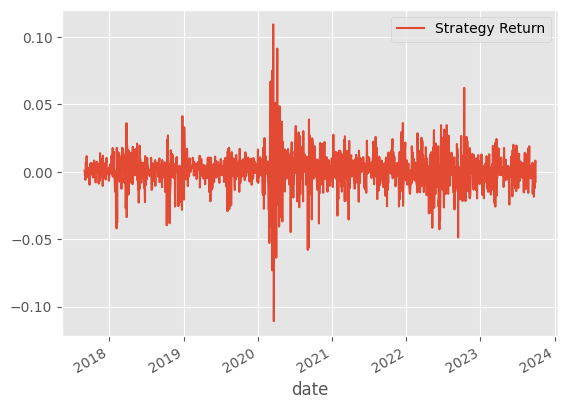

In [455]:
portfolio_df.plot()

## 8. Visualize Portfolio returns and compare to SP500 returns

In [469]:
#Download the return for SP500
spy = yf.download(tickers = 'SPY',
                 start = '2015-01-01',
                 end = dt.date.today())

spy_net = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis = 1)

#merge the portfolio_df with spy_net
portfolio_df = portfolio_df.merge(spy_net,
                                 left_index = True,
                                 right_index = True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold
2017-09-01         0.000700      0.001413
2017-09-05        -0.006001     -0.007208
2017-09-06        -0.001823      0.003408
2017-09-07         0.006840     -0.000121
2017-09-08        -0.001391     -0.001176
...                     ...           ...
2023-09-25         0.003461      0.004196
2023-09-26        -0.012111     -0.014800
2023-09-27         0.004965      0.000399
2023-09-28         0.008159      0.005781
2023-09-29        -0.007472     -0.002430

[1529 rows x 2 columns]

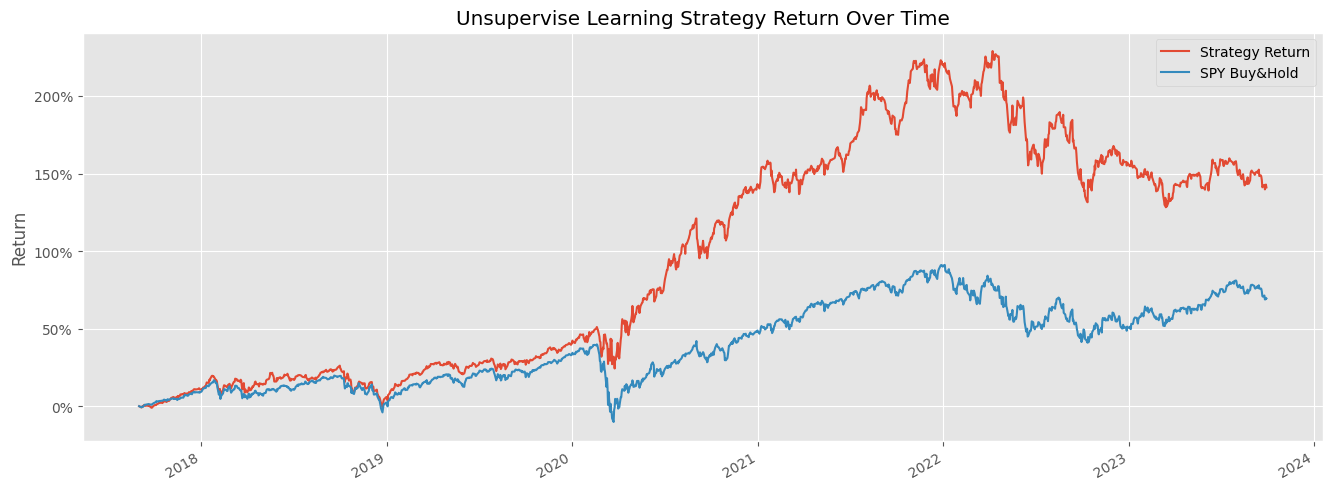

In [478]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')

portfolio_cummulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cummulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervise Learning Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()